# Energy Price Prediction 

## Set-up notebook

In [1]:
#import modules
import pandas as pd
import numpy as np
import os
import datetime
import sklearn

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#other
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

#models
#linear mdels
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV, Lars, Lasso, HuberRegressor, SGDRegressor

#other models
from sklearn import svm

#hparam optimisation
import optuna

#visuals
import seaborn as sns
import matplotlib.pyplot as plt
#show figures inline
%matplotlib inline

#set pandas to show all columns / rows of a dataframe
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#import all timeseries models used

#import detreandring and deseasoning libraries to staionarize lag features
from statsmodels.tsa.seasonal import seasonal_decompose

## Gather Data

### Import used data

In [2]:
#get relevant folders
import os
cur_dir =  os.getcwd()
repo_dir = os.path.join(cur_dir,'..')
energy_data_dir = os.path.join(repo_dir,'data/processed_data/energy/')

def show_datasets():
    #check datasets available
    for file in os.listdir(energy_data_dir):
        print(file)
        
show_datasets()


preprocessed_datetime_onehot_scale_standard.csv
Features_data_merged.csv
preprocessed_datetime_onehot_scale_norm.csv
.ipynb_checkpoints
feature_engineering.ipynb
preprocessed_datetime_cyclic_scale_none.csv
preprocessed_datetime_cyclic_scale_norm.csv
preprocessed_datetime_onehot_scale_none.csv
Archive
features_info.pickle
preprocessed_datetime_cyclic_scale_standard.csv


In [3]:
def load_csv(input_csv):
    '''
    loads data, converts datetime column to datetime format
    input: csv name from datasets folder
    outputs: df
    '''
    data_source = os.path.join(energy_data_dir,input_csv)
    data = pd.read_csv(data_source, low_memory=False)
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data.set_index('datetime')
    if ('Unnamed: 0' in data.columns) == True:
        data = data.drop(columns='Unnamed: 0')
    


    #Replace . with NaN values\n",
    data = data.replace('.', np.nan)
    #Change datatype to numeric\n",
    data = data.apply(pd.to_numeric)

    #Show data
    return data

data = load_csv('preprocessed_datetime_cyclic_scale_none.csv')
data.tail(6)

,SYS_elspot_prices_EUR,SE1_elspot_prices_EUR,SE2_elspot_prices_EUR,SE3_elspot_prices_EUR,SE4_elspot_prices_EUR,FI_elspot_prices_EUR,DK1_elspot_prices_EUR,DK2_elspot_prices_EUR,Oslo_elspot_prices_EUR,Kr.sand_elspot_prices_EUR,Bergen_elspot_prices_EUR,Molde_elspot_prices_EUR,Tr.heim_elspot_prices_EUR,TromsÃ¸_elspot_prices_EUR,EE_elspot_prices_EUR,LV_elspot_prices_EUR,LT_elspot_prices_EUR,NO2_buy_elbas_volume,NO2_sell_elbas_volume,NO3_buy_elbas_volume,NO3_sell_elbas_volume,NO5_sell_elbas_volume,SE1_buy_elbas_volume,SE1_sell_elbas_volume,SE2_buy_elbas_volume,SE2_sell_elbas_volume,SE3_buy_elbas_volume,SE3_sell_elbas_volume,SE4_buy_elbas_volume,SE4_sell_elbas_volume,FI_buy_elbas_volume,FI_sell_elbas_volume,DK1_buy_elbas_volume,DK1_sell_elbas_volume,DK2_buy_elbas_volume,DK2_sell_elbas_volume,EE_buy_elbas_volume,EE_sell_elbas_volume,BE_buy_elbas_volume,BE_sell_elbas_volume,LV_buy_elbas_volume,LV_sell_elbas_volume,LT_buy_elbas_volume,LT_sell_elbas_volume,NO1_production,NO2_production,NO3_production,NO4_production,NO5_production,NO_production,NO1_production_prognosis,NO2_production_prognosis,NO3_production_prognosis,NO4_production_prognosis,NO5_production_prognosis,SE1_production_prognosis,SE2_production_prognosis,SE3_production_prognosis,SE4_production_prognosis,FI_production_prognosis,DK1_production_prognosis,DK2_production_prognosis,EE_production_prognosis,LV_production_prognosis,LT_production_prognosis,SE4_>_DK2_elbas_initial_capacity,DK2_>_SE4_elbas_initial_capacity,SE3_>_DK1_elbas_initial_capacity,DK1_>_SE3_elbas_initial_capacity,SE2_>_SE3_elbas_initial_capacity,SE3_>_SE2_elbas_initial_capacity,SE3_>_SE4_elbas_initial_capacity,SE4_>_SE3_elbas_initial_capacity,SE1_>_FI_elbas_initial_capacity,FI_>_SE1_elbas_initial_capacity,SE3_>_FI_elbas_initial_capacity,FI_>_SE3_elbas_initial_capacity,SE3_>_NO1_elbas_initial_capacity,NO1_>_SE3_elbas_initial_capacity,SE2>_NO4_elbas_initial_capacity,NO4_>_SE2_elbas_initial_capacity,SE2_>_NO3_elbas_initial_capacity,NO3_>_SE2_elbas_initial_capacity,NO2_>_DK1_elbas_initial_capacity,DK1_>_NO2_elbas_initial_capacity,NO3_>_NO4_elbas_initial_capacity,NO4_>_NO3_elbas_initial_capacity,NO4_>_SE1_elbas_initial_capacity,SE1_>_NO4_elbas_initial_capacity,SE1_>_SE2_elbas_initial_capacity,SE2_>_SE1_elbas_initial_capacity,NO1_>_NO3_elbas_initial_capacity,NO3_>_NO1_elbas_initial_capacity,NO5_>_NO2_elbas_initial_capacity,NO2_>_NO5_elbas_initial_capacity,EE_>_FI_elbas_initial_capacity,FI_>_EE_elbas_initial_capacity,DK1_>_DK2_elbas_initial_capacity,DK2_>_DK1_elbas_initial_capacity,NO2_>_NL_elbas_initial_capacity,NL_>_NO2_elbas_initial_capacity,LT_>_LV_elbas_initial_capacity,LV_>_LT_elbas_initial_capacity,EE_>_LV_elbas_initial_capacity,LV_>_EE_elbas_initial_capacity,Turnover_at_system_price_elspot_volumes,NO1_Buy_elspot_volumes,NO1_Sell_elspot_volumes,NO2_Buy_elspot_volumes,NO2_Sell_elspot_volumes,NO3_Buy_elspot_volumes,NO3_Sell_elspot_volumes,NO4_Buy_elspot_volumes,NO4_Sell_elspot_volumes,NO5_Buy_elspot_volumes,NO5_Sell_elspot_volumes,SE1_Buy_elspot_volumes,SE1_Sell_elspot_volumes,SE2_Buy_elspot_volumes,SE2_Sell_elspot_volumes,SE3_Buy_elspot_volumes,SE3_Sell_elspot_volumes,SE4_Buy_elspot_volumes,SE4_Sell_elspot_volumes,FI_Buy_elspot_volumes,FI_Sell_elspot_volumes,DK1_Buy_elspot_volumes,DK1_Sell_elspot_volumes,DK2_Buy_elspot_volumes,DK2_Sell_elspot_volumes,EE_Buy_elspot_volumes,EE_Sell_elspot_volumes,LV_Buy_elspot_volumes,LV_Sell_elspot_volumes,LT_Buy_elspot_volumes,LT_Sell_elspot_volumes,NO_consumption_prognosis,SE_consumption_prognosis,FI_consumption_prognosis,DK1_consumption_prognosis,DK2_consumption_prognosis,EE_consumption_prognosis,LV_consumption_prognosis,LT_consumption_prognosis,Up_regulating_prices_EUR,Down_regulating_prices_EUR,Up.2_regulating_prices_EUR,Down.2_regulating_prices_EUR,Up.3_regulating_prices_EUR,Down.3_regulating_prices_EUR,Up.4_regulating_prices_EUR,Down.4_regulating_prices_EUR,Up.5_regulating_prices_EUR,Down.5_regulating_prices_EUR,Up.6_regulating_prices_EUR,Down.6_regulating_prices_EUR,Up.7_reg

In [4]:
list(data.columns)

['SYS_elspot_prices_EUR',
 'SE1_elspot_prices_EUR',
 'SE2_elspot_prices_EUR',
 'SE3_elspot_prices_EUR',
 'SE4_elspot_prices_EUR',
 'FI_elspot_prices_EUR',
 'DK1_elspot_prices_EUR',
 'DK2_elspot_prices_EUR',
 'Oslo_elspot_prices_EUR',
 'Kr.sand_elspot_prices_EUR',
 'Bergen_elspot_prices_EUR',
 'Molde_elspot_prices_EUR',
 'Tr.heim_elspot_prices_EUR',
 'TromsÃ¸_elspot_prices_EUR',
 'EE_elspot_prices_EUR',
 'LV_elspot_prices_EUR',
 'LT_elspot_prices_EUR',
 'NO2_buy_elbas_volume',
 'NO2_sell_elbas_volume',
 'NO3_buy_elbas_volume',
 'NO3_sell_elbas_volume',
 'NO5_sell_elbas_volume',
 'SE1_buy_elbas_volume',
 'SE1_sell_elbas_volume',
 'SE2_buy_elbas_volume',
 'SE2_sell_elbas_volume',
 'SE3_buy_elbas_volume',
 'SE3_sell_elbas_volume',
 'SE4_buy_elbas_volume',
 'SE4_sell_elbas_volume',
 'FI_buy_elbas_volume',
 'FI_sell_elbas_volume',
 'DK1_buy_elbas_volume',
 'DK1_sell_elbas_volume',
 'DK2_buy_elbas_volume',
 'DK2_sell_elbas_volume',
 'EE_buy_elbas_volume',
 'EE_sell_elbas_volume',
 'BE_buy_elb

### Create training/test split for each price region

In [5]:
#shuffle train/test split
SHUFFLED = True

#use same seed for all train test splits
#r_num = np.random.choice(100)
R_SEED = 42

loaded_df = load_csv('preprocessed_datetime_cyclic_scale_none.csv')
loaded_df = loaded_df.drop(['Kr.sand_elspot_prices_EUR',  'Tr.heim_elspot_prices_EUR',
           'NO1_precipitation','NO2_precipitation','NO3_precipitation','NO4_precipitation','NO5_precipitation',
           'NO_1_Rain_and_snow_melting','NO_2_Rain_and_snow_melting','NO_3_Rain_and_snow_melting','NO_4_Rain_and_snow_melting','NO_5_Rain_and_snow_melting',
 'NO_1_Relative_rain_and_snow-melt_contribution','NO_2_Relative_rain_and_snow-melt_contribution','NO_3_Relative_rain_and_snow-melt_contribution','NO_4_Relative_rain_and_snow-melt_contribution','NO_5_Relative_rain_and_snow-melt_contribution',
 'NO1_soil_saturation','NO2_soil_saturation','NO3_soil_saturation','NO4_soil_saturation','NO5_soil_saturation',
 'NO1_swe','NO2_swe','NO3_swe','NO4_swe','NO5_swe',
 'NO1_temperature','NO2_temperature','NO3_temperature','NO4_temperature','NO5_temperature',], axis=1)


targets_list = ['Oslo_elspot_prices_EUR',
           'Bergen_elspot_prices_EUR',
           'Molde_elspot_prices_EUR',
           'TromsÃ¸_elspot_prices_EUR']


#create 1 day and 2 day before input features for all prices, detrended:
for target_col in targets_list:
    result_mul = seasonal_decompose(loaded_df.loc[:,target_col], model='multiplicative', extrapolate_trend='freq')
    loaded_df[target_col+'_today_dif'] = loaded_df.loc[:,target_col]- result_mul.trend-result_mul.seasonal
    loaded_df[target_col+'_yesterday_dif'] = loaded_df.loc[:,target_col].shift()- result_mul.trend-result_mul.seasonal
    loaded_df[target_col+'_day_before_yesterday_dif'] = loaded_df.loc[:,target_col].shift(2)- result_mul.trend-result_mul.seasonal
    loaded_df[target_col+'_6_days_ago_dif'] = loaded_df.loc[:,target_col].shift(6)- result_mul.trend-result_mul.seasonal
    loaded_df[target_col+'_month_ago_dif'] = loaded_df.loc[:,target_col].shift(29)- result_mul.trend-result_mul.seasonal
    loaded_df[target_col] = loaded_df[target_col].shift(-1)
    
    #loaded_df[target_col+'_yesterday_dif'] = loaded_df.loc[:,target_col].shift()-loaded_df.loc[:,target_col].shift(2)
    #loaded_df[target_col+'_day_before_yesterday_dif'] = loaded_df.loc[:,target_col].shift(2)-loaded_df.loc[:,target_col].shift(3)
    #loaded_df[target_col+'_week_ago_dif'] = loaded_df.loc[:,target_col].shift(7)-loaded_df.loc[:,target_col].shift(8)
    #loaded_df[target_col+'_month_ago_dif'] = loaded_df.loc[:,target_col].shift(29)-loaded_df.loc[:,target_col].shift(30)
    
#drop rows with nans from shift
loaded_df = loaded_df.iloc[31:,:]
loaded_df = loaded_df.iloc[:-1,:]

#subset based on recent data
#years_data_to_include = 7
#loaded_df = loaded_df.iloc[-years_data_to_include*365:,:]

#upsample last years data so model has more recent training data:
one_year_data = loaded_df.iloc[-365:,:].copy()
loaded_df = pd.concat([loaded_df,one_year_data],axis=0)
#loaded_df = pd.concat([loaded_df,one_year_data],axis=0)


#create different dfs to split into input and target feature
oslo_df = loaded_df.copy()
bergen_df = loaded_df.copy()
molde_df = loaded_df.copy()
tromsa_df = loaded_df.copy()
            

# remove other elspot prices from features list

#oslo_df = oslo_df.drop(['Bergen_elspot_prices_EUR', 'Bergen_elspot_prices_EUR_yesterday_dif', 'Bergen_elspot_prices_EUR_day_before_yesterday_dif', 'Bergen_elspot_prices_EUR_week_ago_dif', 'Bergen_elspot_prices_EUR_month_ago_dif',
#             'Molde_elspot_prices_EUR', 'Molde_elspot_prices_EUR_yesterday_dif', 'Molde_elspot_prices_EUR_day_before_yesterday_dif', 'Molde_elspot_prices_EUR_week_ago_dif', 'Molde_elspot_prices_EUR_month_ago_dif',
#             'TromsÃ¸_elspot_prices_EUR', 'TromsÃ¸_elspot_prices_EUR_yesterday_dif', 'TromsÃ¸_elspot_prices_EUR_day_before_yesterday_dif', 'TromsÃ¸_elspot_prices_EUR_week_ago_dif', 'TromsÃ¸_elspot_prices_EUR_month_ago_dif'],
#             axis=1)
#bergen_df = bergen_df.drop(['Oslo_elspot_prices_EUR', 'Oslo_elspot_prices_EUR_yesterday_dif', 'Oslo_elspot_prices_EUR_day_before_yesterday_dif', 'Oslo_elspot_prices_EUR_week_ago_dif', 'Oslo_elspot_prices_EUR_month_ago_dif',
#             'Molde_elspot_prices_EUR', 'Molde_elspot_prices_EUR_yesterday_dif', 'Molde_elspot_prices_EUR_day_before_yesterday_dif', 'Molde_elspot_prices_EUR_week_ago_dif', 'Molde_elspot_prices_EUR_month_ago_dif',
#             'TromsÃ¸_elspot_prices_EUR', 'TromsÃ¸_elspot_prices_EUR_yesterday_dif', 'TromsÃ¸_elspot_prices_EUR_day_before_yesterday_dif', 'TromsÃ¸_elspot_prices_EUR_week_ago_dif', 'TromsÃ¸_elspot_prices_EUR_month_ago_dif'],
#             axis=1)
#molde_df = molde_df.drop(['Oslo_elspot_prices_EUR', 'Oslo_elspot_prices_EUR_yesterday_dif', 'Oslo_elspot_prices_EUR_day_before_yesterday_dif', 'Oslo_elspot_prices_EUR_week_ago_dif', 'Oslo_elspot_prices_EUR_month_ago_dif',
#             'Bergen_elspot_prices_EUR', 'Bergen_elspot_prices_EUR_yesterday_dif', 'Bergen_elspot_prices_EUR_day_before_yesterday_dif', 'Bergen_elspot_prices_EUR_week_ago_dif', 'Bergen_elspot_prices_EUR_month_ago_dif',
#             'TromsÃ¸_elspot_prices_EUR', 'TromsÃ¸_elspot_prices_EUR_yesterday_dif', 'TromsÃ¸_elspot_prices_EUR_day_before_yesterday_dif', 'TromsÃ¸_elspot_prices_EUR_week_ago_dif', 'TromsÃ¸_elspot_prices_EUR_month_ago_dif'],
#             axis=1)
#tromsa_df = tromsa_df.drop(['Oslo_elspot_prices_EUR', 'Oslo_elspot_prices_EUR_yesterday_dif', 'Oslo_elspot_prices_EUR_day_before_yesterday_dif', 'Oslo_elspot_prices_EUR_week_ago_dif', 'Oslo_elspot_prices_EUR_month_ago_dif',
#             'Bergen_elspot_prices_EUR', 'Bergen_elspot_prices_EUR_yesterday_dif', 'Bergen_elspot_prices_EUR_day_before_yesterday_dif', 'Bergen_elspot_prices_EUR_week_ago_dif', 'Bergen_elspot_prices_EUR_month_ago_dif',
#            'Molde_elspot_prices_EUR', 'Molde_elspot_prices_EUR_yesterday_dif', 'Molde_elspot_prices_EUR_day_before_yesterday_dif', 'Molde_elspot_prices_EUR_week_ago_dif', 'Molde_elspot_prices_EUR_month_ago_dif'],
#             axis=1)


df_list = [oslo_df,bergen_df,molde_df,tromsa_df]

def scale_make_train_test_split(target):
    #TODO: this could be more efficient as the input features are scaled 6 times (once for each target price)
    
    '''
    splits df into features and target, scales nondatetime features and 
    then splits into training and testing splits
    inputs: target 0,1,2,3 corresponding to certain target price region
    outputs: a list with 4 elements: [features_scaled_train,target_train,features_scaled_test,target_test]
    
    '''
    
    #get df to edit
    temp_df = df_list[target].copy()
    
    #assign target and features
    temp_target_name = targets_list[target]
    
    #separate into features and target df
    #temp_features = temp_df.drop(columns=temp_target_name, axis=1).copy()
    temp_target = temp_df.loc[:,temp_target_name].copy()

    #drop all target features from the input features since they are all prices for day ahead   
    for any_target in targets_list:
        temp_df=temp_df.drop(columns=any_target, axis=1)

        
    #apply scaling to nondatetime features:
    temp_features_scaled = temp_df.copy()
    
    for column in temp_features_scaled.columns:
        if ('date' in column) == False:
            input_feature =  temp_features_scaled[[column]].copy() #reshape as fit expects df and not single feature
            scaler = preprocessing.StandardScaler().fit(input_feature.values) 
            temp_features_scaled[column] = scaler.transform(input_feature.values)
        else:
            #move onto next column
            pass
    
    #create train/test split x_train, x_test,y_train,y_test
    temp_features_train, temp_features_test, temp_target_train, temp_target_test = train_test_split(temp_features_scaled, temp_target, 
                                                                                                    test_size=0.05, 
                                                                                                    shuffle=SHUFFLED,random_state=R_SEED)
    
    #output datasets as list
    return [temp_features_train, temp_features_test, temp_target_train, temp_target_test]

oslo_train_test = scale_make_train_test_split(0)
bergen_train_test = scale_make_train_test_split(1)
molde_train_test = scale_make_train_test_split(2)
tromsa_train_test = scale_make_train_test_split(3)

train_test_list = [oslo_train_test,
                   bergen_train_test,molde_train_test,
                  tromsa_train_test]

In [6]:
#loaded_df1 = loaded_df.iloc[-365:,:].copy()

#plt.figure(figsize=(20,5))
#plt.plot(loaded_df1.index,loaded_df1['Molde_elspot_prices_EUR_yesterday_dif'].values,label='Molde_elspot_prices_EUR_yesterday_dif')
#plt.plot(loaded_df1.index,loaded_df1['Molde_elspot_prices_EUR_week_ago_dif'].values,label = 'Molde_elspot_prices_EUR_week_ago_dif')
#plt.plot(loaded_df1.index,loaded_df1['Molde_elspot_prices_EUR'].values,label = 'Molde_elspot_prices_EUR')

#plt.legend()
#plt.grid(which='both',axis='both')

### Examine train/test splits

In [7]:
#train_x
oslo_train_test[0].head()

,SYS_elspot_prices_EUR,SE1_elspot_prices_EUR,SE2_elspot_prices_EUR,SE3_elspot_prices_EUR,SE4_elspot_prices_EUR,FI_elspot_prices_EUR,DK1_elspot_prices_EUR,DK2_elspot_prices_EUR,EE_elspot_prices_EUR,LV_elspot_prices_EUR,LT_elspot_prices_EUR,NO2_buy_elbas_volume,NO2_sell_elbas_volume,NO3_buy_elbas_volume,NO3_sell_elbas_volume,NO5_sell_elbas_volume,SE1_buy_elbas_volume,SE1_sell_elbas_volume,SE2_buy_elbas_volume,SE2_sell_elbas_volume,SE3_buy_elbas_volume,SE3_sell_elbas_volume,SE4_buy_elbas_volume,SE4_sell_elbas_volume,FI_buy_elbas_volume,FI_sell_elbas_volume,DK1_buy_elbas_volume,DK1_sell_elbas_volume,DK2_buy_elbas_volume,DK2_sell_elbas_volume,EE_buy_elbas_volume,EE_sell_elbas_volume,BE_buy_elbas_volume,BE_sell_elbas_volume,LV_buy_elbas_volume,LV_sell_elbas_volume,LT_buy_elbas_volume,LT_sell_elbas_volume,NO1_production,NO2_production,NO3_production,NO4_production,NO5_production,NO_production,NO1_production_prognosis,NO2_production_prognosis,NO3_production_prognosis,NO4_production_prognosis,NO5_production_prognosis,SE1_production_prognosis,SE2_production_prognosis,SE3_production_prognosis,SE4_production_prognosis,FI_production_prognosis,DK1_production_prognosis,DK2_production_prognosis,EE_production_prognosis,LV_production_prognosis,LT_production_prognosis,SE4_>_DK2_elbas_initial_capacity,DK2_>_SE4_elbas_initial_capacity,SE3_>_DK1_elbas_initial_capacity,DK1_>_SE3_elbas_initial_capacity,SE2_>_SE3_elbas_initial_capacity,SE3_>_SE2_elbas_initial_capacity,SE3_>_SE4_elbas_initial_capacity,SE4_>_SE3_elbas_initial_capacity,SE1_>_FI_elbas_initial_capacity,FI_>_SE1_elbas_initial_capacity,SE3_>_FI_elbas_initial_capacity,FI_>_SE3_elbas_initial_capacity,SE3_>_NO1_elbas_initial_capacity,NO1_>_SE3_elbas_initial_capacity,SE2>_NO4_elbas_initial_capacity,NO4_>_SE2_elbas_initial_capacity,SE2_>_NO3_elbas_initial_capacity,NO3_>_SE2_elbas_initial_capacity,NO2_>_DK1_elbas_initial_capacity,DK1_>_NO2_elbas_initial_capacity,NO3_>_NO4_elbas_initial_capacity,NO4_>_NO3_elbas_initial_capacity,NO4_>_SE1_elbas_initial_capacity,SE1_>_NO4_elbas_initial_capacity,SE1_>_SE2_elbas_initial_capacity,SE2_>_SE1_elbas_initial_capacity,NO1_>_NO3_elbas_initial_capacity,NO3_>_NO1_elbas_initial_capacity,NO5_>_NO2_elbas_initial_capacity,NO2_>_NO5_elbas_initial_capacity,EE_>_FI_elbas_initial_capacity,FI_>_EE_elbas_initial_capacity,DK1_>_DK2_elbas_initial_capacity,DK2_>_DK1_elbas_initial_capacity,NO2_>_NL_elbas_initial_capacity,NL_>_NO2_elbas_initial_capacity,LT_>_LV_elbas_initial_capacity,LV_>_LT_elbas_initial_capacity,EE_>_LV_elbas_initial_capacity,LV_>_EE_elbas_initial_capacity,Turnover_at_system_price_elspot_volumes,NO1_Buy_elspot_volumes,NO1_Sell_elspot_volumes,NO2_Buy_elspot_volumes,NO2_Sell_elspot_volumes,NO3_Buy_elspot_volumes,NO3_Sell_elspot_volumes,NO4_Buy_elspot_volumes,NO4_Sell_elspot_volumes,NO5_Buy_elspot_volumes,NO5_Sell_elspot_volumes,SE1_Buy_elspot_volumes,SE1_Sell_elspot_volumes,SE2_Buy_elspot_volumes,SE2_Sell_elspot_volumes,SE3_Buy_elspot_volumes,SE3_Sell_elspot_volumes,SE4_Buy_elspot_volumes,SE4_Sell_elspot_volumes,FI_Buy_elspot_volumes,FI_Sell_elspot_volumes,DK1_Buy_elspot_volumes,DK1_Sell_elspot_volumes,DK2_Buy_elspot_volumes,DK2_Sell_elspot_volumes,EE_Buy_elspot_volumes,EE_Sell_elspot_volumes,LV_Buy_elspot_volumes,LV_Sell_elspot_volumes,LT_Buy_elspot_volumes,LT_Sell_elspot_volumes,NO_consumption_prognosis,SE_consumption_prognosis,FI_consumption_prognosis,DK1_consumption_prognosis,DK2_consumption_prognosis,EE_consumption_prognosis,LV_consumption_prognosis,LT_consumption_prognosis,Up_regulating_prices_EUR,Down_regulating_prices_EUR,Up.2_regulating_prices_EUR,Down.2_regulating_prices_EUR,Up.3_regulating_prices_EUR,Down.3_regulating_prices_EUR,Up.4_regulating_prices_EUR,Down.4_regulating_prices_EUR,Up.5_regulating_prices_EUR,Down.5_regulating_prices_EUR,Up.6_regulating_prices_EUR,Down.6_regulating_prices_EUR,Up.7_regulating_prices_EUR,Down.7_regulating_prices_EUR,Up.8_regulating_prices_EUR,Down.8_regulating_prices_EUR,Up.9_regulating_prices_EUR,Down.9_regulating_p

In [8]:
#train_y
oslo_train_test[2].head()

datetime
2020-01-06    29.60
2021-05-15    35.51
2018-02-01    35.53
2019-07-27    35.40
2020-01-16    24.45
Name: Oslo_elspot_prices_EUR, dtype: float64

In [9]:
#test_x
oslo_train_test[1].head()

,SYS_elspot_prices_EUR,SE1_elspot_prices_EUR,SE2_elspot_prices_EUR,SE3_elspot_prices_EUR,SE4_elspot_prices_EUR,FI_elspot_prices_EUR,DK1_elspot_prices_EUR,DK2_elspot_prices_EUR,EE_elspot_prices_EUR,LV_elspot_prices_EUR,LT_elspot_prices_EUR,NO2_buy_elbas_volume,NO2_sell_elbas_volume,NO3_buy_elbas_volume,NO3_sell_elbas_volume,NO5_sell_elbas_volume,SE1_buy_elbas_volume,SE1_sell_elbas_volume,SE2_buy_elbas_volume,SE2_sell_elbas_volume,SE3_buy_elbas_volume,SE3_sell_elbas_volume,SE4_buy_elbas_volume,SE4_sell_elbas_volume,FI_buy_elbas_volume,FI_sell_elbas_volume,DK1_buy_elbas_volume,DK1_sell_elbas_volume,DK2_buy_elbas_volume,DK2_sell_elbas_volume,EE_buy_elbas_volume,EE_sell_elbas_volume,BE_buy_elbas_volume,BE_sell_elbas_volume,LV_buy_elbas_volume,LV_sell_elbas_volume,LT_buy_elbas_volume,LT_sell_elbas_volume,NO1_production,NO2_production,NO3_production,NO4_production,NO5_production,NO_production,NO1_production_prognosis,NO2_production_prognosis,NO3_production_prognosis,NO4_production_prognosis,NO5_production_prognosis,SE1_production_prognosis,SE2_production_prognosis,SE3_production_prognosis,SE4_production_prognosis,FI_production_prognosis,DK1_production_prognosis,DK2_production_prognosis,EE_production_prognosis,LV_production_prognosis,LT_production_prognosis,SE4_>_DK2_elbas_initial_capacity,DK2_>_SE4_elbas_initial_capacity,SE3_>_DK1_elbas_initial_capacity,DK1_>_SE3_elbas_initial_capacity,SE2_>_SE3_elbas_initial_capacity,SE3_>_SE2_elbas_initial_capacity,SE3_>_SE4_elbas_initial_capacity,SE4_>_SE3_elbas_initial_capacity,SE1_>_FI_elbas_initial_capacity,FI_>_SE1_elbas_initial_capacity,SE3_>_FI_elbas_initial_capacity,FI_>_SE3_elbas_initial_capacity,SE3_>_NO1_elbas_initial_capacity,NO1_>_SE3_elbas_initial_capacity,SE2>_NO4_elbas_initial_capacity,NO4_>_SE2_elbas_initial_capacity,SE2_>_NO3_elbas_initial_capacity,NO3_>_SE2_elbas_initial_capacity,NO2_>_DK1_elbas_initial_capacity,DK1_>_NO2_elbas_initial_capacity,NO3_>_NO4_elbas_initial_capacity,NO4_>_NO3_elbas_initial_capacity,NO4_>_SE1_elbas_initial_capacity,SE1_>_NO4_elbas_initial_capacity,SE1_>_SE2_elbas_initial_capacity,SE2_>_SE1_elbas_initial_capacity,NO1_>_NO3_elbas_initial_capacity,NO3_>_NO1_elbas_initial_capacity,NO5_>_NO2_elbas_initial_capacity,NO2_>_NO5_elbas_initial_capacity,EE_>_FI_elbas_initial_capacity,FI_>_EE_elbas_initial_capacity,DK1_>_DK2_elbas_initial_capacity,DK2_>_DK1_elbas_initial_capacity,NO2_>_NL_elbas_initial_capacity,NL_>_NO2_elbas_initial_capacity,LT_>_LV_elbas_initial_capacity,LV_>_LT_elbas_initial_capacity,EE_>_LV_elbas_initial_capacity,LV_>_EE_elbas_initial_capacity,Turnover_at_system_price_elspot_volumes,NO1_Buy_elspot_volumes,NO1_Sell_elspot_volumes,NO2_Buy_elspot_volumes,NO2_Sell_elspot_volumes,NO3_Buy_elspot_volumes,NO3_Sell_elspot_volumes,NO4_Buy_elspot_volumes,NO4_Sell_elspot_volumes,NO5_Buy_elspot_volumes,NO5_Sell_elspot_volumes,SE1_Buy_elspot_volumes,SE1_Sell_elspot_volumes,SE2_Buy_elspot_volumes,SE2_Sell_elspot_volumes,SE3_Buy_elspot_volumes,SE3_Sell_elspot_volumes,SE4_Buy_elspot_volumes,SE4_Sell_elspot_volumes,FI_Buy_elspot_volumes,FI_Sell_elspot_volumes,DK1_Buy_elspot_volumes,DK1_Sell_elspot_volumes,DK2_Buy_elspot_volumes,DK2_Sell_elspot_volumes,EE_Buy_elspot_volumes,EE_Sell_elspot_volumes,LV_Buy_elspot_volumes,LV_Sell_elspot_volumes,LT_Buy_elspot_volumes,LT_Sell_elspot_volumes,NO_consumption_prognosis,SE_consumption_prognosis,FI_consumption_prognosis,DK1_consumption_prognosis,DK2_consumption_prognosis,EE_consumption_prognosis,LV_consumption_prognosis,LT_consumption_prognosis,Up_regulating_prices_EUR,Down_regulating_prices_EUR,Up.2_regulating_prices_EUR,Down.2_regulating_prices_EUR,Up.3_regulating_prices_EUR,Down.3_regulating_prices_EUR,Up.4_regulating_prices_EUR,Down.4_regulating_prices_EUR,Up.5_regulating_prices_EUR,Down.5_regulating_prices_EUR,Up.6_regulating_prices_EUR,Down.6_regulating_prices_EUR,Up.7_regulating_prices_EUR,Down.7_regulating_prices_EUR,Up.8_regulating_prices_EUR,Down.8_regulating_prices_EUR,Up.9_regulating_prices_EUR,Down.9_regulating_p

In [10]:
#test_y
oslo_train_test[3].head()

datetime
2020-10-03     4.06
2019-01-20    68.46
2014-10-10    31.85
2021-02-08    69.36
2016-12-07    30.89
Name: Oslo_elspot_prices_EUR, dtype: float64

In [11]:
#train_x
molde_train_test[0].head()

,SYS_elspot_prices_EUR,SE1_elspot_prices_EUR,SE2_elspot_prices_EUR,SE3_elspot_prices_EUR,SE4_elspot_prices_EUR,FI_elspot_prices_EUR,DK1_elspot_prices_EUR,DK2_elspot_prices_EUR,EE_elspot_prices_EUR,LV_elspot_prices_EUR,LT_elspot_prices_EUR,NO2_buy_elbas_volume,NO2_sell_elbas_volume,NO3_buy_elbas_volume,NO3_sell_elbas_volume,NO5_sell_elbas_volume,SE1_buy_elbas_volume,SE1_sell_elbas_volume,SE2_buy_elbas_volume,SE2_sell_elbas_volume,SE3_buy_elbas_volume,SE3_sell_elbas_volume,SE4_buy_elbas_volume,SE4_sell_elbas_volume,FI_buy_elbas_volume,FI_sell_elbas_volume,DK1_buy_elbas_volume,DK1_sell_elbas_volume,DK2_buy_elbas_volume,DK2_sell_elbas_volume,EE_buy_elbas_volume,EE_sell_elbas_volume,BE_buy_elbas_volume,BE_sell_elbas_volume,LV_buy_elbas_volume,LV_sell_elbas_volume,LT_buy_elbas_volume,LT_sell_elbas_volume,NO1_production,NO2_production,NO3_production,NO4_production,NO5_production,NO_production,NO1_production_prognosis,NO2_production_prognosis,NO3_production_prognosis,NO4_production_prognosis,NO5_production_prognosis,SE1_production_prognosis,SE2_production_prognosis,SE3_production_prognosis,SE4_production_prognosis,FI_production_prognosis,DK1_production_prognosis,DK2_production_prognosis,EE_production_prognosis,LV_production_prognosis,LT_production_prognosis,SE4_>_DK2_elbas_initial_capacity,DK2_>_SE4_elbas_initial_capacity,SE3_>_DK1_elbas_initial_capacity,DK1_>_SE3_elbas_initial_capacity,SE2_>_SE3_elbas_initial_capacity,SE3_>_SE2_elbas_initial_capacity,SE3_>_SE4_elbas_initial_capacity,SE4_>_SE3_elbas_initial_capacity,SE1_>_FI_elbas_initial_capacity,FI_>_SE1_elbas_initial_capacity,SE3_>_FI_elbas_initial_capacity,FI_>_SE3_elbas_initial_capacity,SE3_>_NO1_elbas_initial_capacity,NO1_>_SE3_elbas_initial_capacity,SE2>_NO4_elbas_initial_capacity,NO4_>_SE2_elbas_initial_capacity,SE2_>_NO3_elbas_initial_capacity,NO3_>_SE2_elbas_initial_capacity,NO2_>_DK1_elbas_initial_capacity,DK1_>_NO2_elbas_initial_capacity,NO3_>_NO4_elbas_initial_capacity,NO4_>_NO3_elbas_initial_capacity,NO4_>_SE1_elbas_initial_capacity,SE1_>_NO4_elbas_initial_capacity,SE1_>_SE2_elbas_initial_capacity,SE2_>_SE1_elbas_initial_capacity,NO1_>_NO3_elbas_initial_capacity,NO3_>_NO1_elbas_initial_capacity,NO5_>_NO2_elbas_initial_capacity,NO2_>_NO5_elbas_initial_capacity,EE_>_FI_elbas_initial_capacity,FI_>_EE_elbas_initial_capacity,DK1_>_DK2_elbas_initial_capacity,DK2_>_DK1_elbas_initial_capacity,NO2_>_NL_elbas_initial_capacity,NL_>_NO2_elbas_initial_capacity,LT_>_LV_elbas_initial_capacity,LV_>_LT_elbas_initial_capacity,EE_>_LV_elbas_initial_capacity,LV_>_EE_elbas_initial_capacity,Turnover_at_system_price_elspot_volumes,NO1_Buy_elspot_volumes,NO1_Sell_elspot_volumes,NO2_Buy_elspot_volumes,NO2_Sell_elspot_volumes,NO3_Buy_elspot_volumes,NO3_Sell_elspot_volumes,NO4_Buy_elspot_volumes,NO4_Sell_elspot_volumes,NO5_Buy_elspot_volumes,NO5_Sell_elspot_volumes,SE1_Buy_elspot_volumes,SE1_Sell_elspot_volumes,SE2_Buy_elspot_volumes,SE2_Sell_elspot_volumes,SE3_Buy_elspot_volumes,SE3_Sell_elspot_volumes,SE4_Buy_elspot_volumes,SE4_Sell_elspot_volumes,FI_Buy_elspot_volumes,FI_Sell_elspot_volumes,DK1_Buy_elspot_volumes,DK1_Sell_elspot_volumes,DK2_Buy_elspot_volumes,DK2_Sell_elspot_volumes,EE_Buy_elspot_volumes,EE_Sell_elspot_volumes,LV_Buy_elspot_volumes,LV_Sell_elspot_volumes,LT_Buy_elspot_volumes,LT_Sell_elspot_volumes,NO_consumption_prognosis,SE_consumption_prognosis,FI_consumption_prognosis,DK1_consumption_prognosis,DK2_consumption_prognosis,EE_consumption_prognosis,LV_consumption_prognosis,LT_consumption_prognosis,Up_regulating_prices_EUR,Down_regulating_prices_EUR,Up.2_regulating_prices_EUR,Down.2_regulating_prices_EUR,Up.3_regulating_prices_EUR,Down.3_regulating_prices_EUR,Up.4_regulating_prices_EUR,Down.4_regulating_prices_EUR,Up.5_regulating_prices_EUR,Down.5_regulating_prices_EUR,Up.6_regulating_prices_EUR,Down.6_regulating_prices_EUR,Up.7_regulating_prices_EUR,Down.7_regulating_prices_EUR,Up.8_regulating_prices_EUR,Down.8_regulating_prices_EUR,Up.9_regulating_prices_EUR,Down.9_regulating_p

In [12]:
#train_x
bergen_train_test[0].head()

,SYS_elspot_prices_EUR,SE1_elspot_prices_EUR,SE2_elspot_prices_EUR,SE3_elspot_prices_EUR,SE4_elspot_prices_EUR,FI_elspot_prices_EUR,DK1_elspot_prices_EUR,DK2_elspot_prices_EUR,EE_elspot_prices_EUR,LV_elspot_prices_EUR,LT_elspot_prices_EUR,NO2_buy_elbas_volume,NO2_sell_elbas_volume,NO3_buy_elbas_volume,NO3_sell_elbas_volume,NO5_sell_elbas_volume,SE1_buy_elbas_volume,SE1_sell_elbas_volume,SE2_buy_elbas_volume,SE2_sell_elbas_volume,SE3_buy_elbas_volume,SE3_sell_elbas_volume,SE4_buy_elbas_volume,SE4_sell_elbas_volume,FI_buy_elbas_volume,FI_sell_elbas_volume,DK1_buy_elbas_volume,DK1_sell_elbas_volume,DK2_buy_elbas_volume,DK2_sell_elbas_volume,EE_buy_elbas_volume,EE_sell_elbas_volume,BE_buy_elbas_volume,BE_sell_elbas_volume,LV_buy_elbas_volume,LV_sell_elbas_volume,LT_buy_elbas_volume,LT_sell_elbas_volume,NO1_production,NO2_production,NO3_production,NO4_production,NO5_production,NO_production,NO1_production_prognosis,NO2_production_prognosis,NO3_production_prognosis,NO4_production_prognosis,NO5_production_prognosis,SE1_production_prognosis,SE2_production_prognosis,SE3_production_prognosis,SE4_production_prognosis,FI_production_prognosis,DK1_production_prognosis,DK2_production_prognosis,EE_production_prognosis,LV_production_prognosis,LT_production_prognosis,SE4_>_DK2_elbas_initial_capacity,DK2_>_SE4_elbas_initial_capacity,SE3_>_DK1_elbas_initial_capacity,DK1_>_SE3_elbas_initial_capacity,SE2_>_SE3_elbas_initial_capacity,SE3_>_SE2_elbas_initial_capacity,SE3_>_SE4_elbas_initial_capacity,SE4_>_SE3_elbas_initial_capacity,SE1_>_FI_elbas_initial_capacity,FI_>_SE1_elbas_initial_capacity,SE3_>_FI_elbas_initial_capacity,FI_>_SE3_elbas_initial_capacity,SE3_>_NO1_elbas_initial_capacity,NO1_>_SE3_elbas_initial_capacity,SE2>_NO4_elbas_initial_capacity,NO4_>_SE2_elbas_initial_capacity,SE2_>_NO3_elbas_initial_capacity,NO3_>_SE2_elbas_initial_capacity,NO2_>_DK1_elbas_initial_capacity,DK1_>_NO2_elbas_initial_capacity,NO3_>_NO4_elbas_initial_capacity,NO4_>_NO3_elbas_initial_capacity,NO4_>_SE1_elbas_initial_capacity,SE1_>_NO4_elbas_initial_capacity,SE1_>_SE2_elbas_initial_capacity,SE2_>_SE1_elbas_initial_capacity,NO1_>_NO3_elbas_initial_capacity,NO3_>_NO1_elbas_initial_capacity,NO5_>_NO2_elbas_initial_capacity,NO2_>_NO5_elbas_initial_capacity,EE_>_FI_elbas_initial_capacity,FI_>_EE_elbas_initial_capacity,DK1_>_DK2_elbas_initial_capacity,DK2_>_DK1_elbas_initial_capacity,NO2_>_NL_elbas_initial_capacity,NL_>_NO2_elbas_initial_capacity,LT_>_LV_elbas_initial_capacity,LV_>_LT_elbas_initial_capacity,EE_>_LV_elbas_initial_capacity,LV_>_EE_elbas_initial_capacity,Turnover_at_system_price_elspot_volumes,NO1_Buy_elspot_volumes,NO1_Sell_elspot_volumes,NO2_Buy_elspot_volumes,NO2_Sell_elspot_volumes,NO3_Buy_elspot_volumes,NO3_Sell_elspot_volumes,NO4_Buy_elspot_volumes,NO4_Sell_elspot_volumes,NO5_Buy_elspot_volumes,NO5_Sell_elspot_volumes,SE1_Buy_elspot_volumes,SE1_Sell_elspot_volumes,SE2_Buy_elspot_volumes,SE2_Sell_elspot_volumes,SE3_Buy_elspot_volumes,SE3_Sell_elspot_volumes,SE4_Buy_elspot_volumes,SE4_Sell_elspot_volumes,FI_Buy_elspot_volumes,FI_Sell_elspot_volumes,DK1_Buy_elspot_volumes,DK1_Sell_elspot_volumes,DK2_Buy_elspot_volumes,DK2_Sell_elspot_volumes,EE_Buy_elspot_volumes,EE_Sell_elspot_volumes,LV_Buy_elspot_volumes,LV_Sell_elspot_volumes,LT_Buy_elspot_volumes,LT_Sell_elspot_volumes,NO_consumption_prognosis,SE_consumption_prognosis,FI_consumption_prognosis,DK1_consumption_prognosis,DK2_consumption_prognosis,EE_consumption_prognosis,LV_consumption_prognosis,LT_consumption_prognosis,Up_regulating_prices_EUR,Down_regulating_prices_EUR,Up.2_regulating_prices_EUR,Down.2_regulating_prices_EUR,Up.3_regulating_prices_EUR,Down.3_regulating_prices_EUR,Up.4_regulating_prices_EUR,Down.4_regulating_prices_EUR,Up.5_regulating_prices_EUR,Down.5_regulating_prices_EUR,Up.6_regulating_prices_EUR,Down.6_regulating_prices_EUR,Up.7_regulating_prices_EUR,Down.7_regulating_prices_EUR,Up.8_regulating_prices_EUR,Down.8_regulating_prices_EUR,Up.9_regulating_prices_EUR,Down.9_regulating_p

In [13]:
#test_x
bergen_train_test[1].head()

,SYS_elspot_prices_EUR,SE1_elspot_prices_EUR,SE2_elspot_prices_EUR,SE3_elspot_prices_EUR,SE4_elspot_prices_EUR,FI_elspot_prices_EUR,DK1_elspot_prices_EUR,DK2_elspot_prices_EUR,EE_elspot_prices_EUR,LV_elspot_prices_EUR,LT_elspot_prices_EUR,NO2_buy_elbas_volume,NO2_sell_elbas_volume,NO3_buy_elbas_volume,NO3_sell_elbas_volume,NO5_sell_elbas_volume,SE1_buy_elbas_volume,SE1_sell_elbas_volume,SE2_buy_elbas_volume,SE2_sell_elbas_volume,SE3_buy_elbas_volume,SE3_sell_elbas_volume,SE4_buy_elbas_volume,SE4_sell_elbas_volume,FI_buy_elbas_volume,FI_sell_elbas_volume,DK1_buy_elbas_volume,DK1_sell_elbas_volume,DK2_buy_elbas_volume,DK2_sell_elbas_volume,EE_buy_elbas_volume,EE_sell_elbas_volume,BE_buy_elbas_volume,BE_sell_elbas_volume,LV_buy_elbas_volume,LV_sell_elbas_volume,LT_buy_elbas_volume,LT_sell_elbas_volume,NO1_production,NO2_production,NO3_production,NO4_production,NO5_production,NO_production,NO1_production_prognosis,NO2_production_prognosis,NO3_production_prognosis,NO4_production_prognosis,NO5_production_prognosis,SE1_production_prognosis,SE2_production_prognosis,SE3_production_prognosis,SE4_production_prognosis,FI_production_prognosis,DK1_production_prognosis,DK2_production_prognosis,EE_production_prognosis,LV_production_prognosis,LT_production_prognosis,SE4_>_DK2_elbas_initial_capacity,DK2_>_SE4_elbas_initial_capacity,SE3_>_DK1_elbas_initial_capacity,DK1_>_SE3_elbas_initial_capacity,SE2_>_SE3_elbas_initial_capacity,SE3_>_SE2_elbas_initial_capacity,SE3_>_SE4_elbas_initial_capacity,SE4_>_SE3_elbas_initial_capacity,SE1_>_FI_elbas_initial_capacity,FI_>_SE1_elbas_initial_capacity,SE3_>_FI_elbas_initial_capacity,FI_>_SE3_elbas_initial_capacity,SE3_>_NO1_elbas_initial_capacity,NO1_>_SE3_elbas_initial_capacity,SE2>_NO4_elbas_initial_capacity,NO4_>_SE2_elbas_initial_capacity,SE2_>_NO3_elbas_initial_capacity,NO3_>_SE2_elbas_initial_capacity,NO2_>_DK1_elbas_initial_capacity,DK1_>_NO2_elbas_initial_capacity,NO3_>_NO4_elbas_initial_capacity,NO4_>_NO3_elbas_initial_capacity,NO4_>_SE1_elbas_initial_capacity,SE1_>_NO4_elbas_initial_capacity,SE1_>_SE2_elbas_initial_capacity,SE2_>_SE1_elbas_initial_capacity,NO1_>_NO3_elbas_initial_capacity,NO3_>_NO1_elbas_initial_capacity,NO5_>_NO2_elbas_initial_capacity,NO2_>_NO5_elbas_initial_capacity,EE_>_FI_elbas_initial_capacity,FI_>_EE_elbas_initial_capacity,DK1_>_DK2_elbas_initial_capacity,DK2_>_DK1_elbas_initial_capacity,NO2_>_NL_elbas_initial_capacity,NL_>_NO2_elbas_initial_capacity,LT_>_LV_elbas_initial_capacity,LV_>_LT_elbas_initial_capacity,EE_>_LV_elbas_initial_capacity,LV_>_EE_elbas_initial_capacity,Turnover_at_system_price_elspot_volumes,NO1_Buy_elspot_volumes,NO1_Sell_elspot_volumes,NO2_Buy_elspot_volumes,NO2_Sell_elspot_volumes,NO3_Buy_elspot_volumes,NO3_Sell_elspot_volumes,NO4_Buy_elspot_volumes,NO4_Sell_elspot_volumes,NO5_Buy_elspot_volumes,NO5_Sell_elspot_volumes,SE1_Buy_elspot_volumes,SE1_Sell_elspot_volumes,SE2_Buy_elspot_volumes,SE2_Sell_elspot_volumes,SE3_Buy_elspot_volumes,SE3_Sell_elspot_volumes,SE4_Buy_elspot_volumes,SE4_Sell_elspot_volumes,FI_Buy_elspot_volumes,FI_Sell_elspot_volumes,DK1_Buy_elspot_volumes,DK1_Sell_elspot_volumes,DK2_Buy_elspot_volumes,DK2_Sell_elspot_volumes,EE_Buy_elspot_volumes,EE_Sell_elspot_volumes,LV_Buy_elspot_volumes,LV_Sell_elspot_volumes,LT_Buy_elspot_volumes,LT_Sell_elspot_volumes,NO_consumption_prognosis,SE_consumption_prognosis,FI_consumption_prognosis,DK1_consumption_prognosis,DK2_consumption_prognosis,EE_consumption_prognosis,LV_consumption_prognosis,LT_consumption_prognosis,Up_regulating_prices_EUR,Down_regulating_prices_EUR,Up.2_regulating_prices_EUR,Down.2_regulating_prices_EUR,Up.3_regulating_prices_EUR,Down.3_regulating_prices_EUR,Up.4_regulating_prices_EUR,Down.4_regulating_prices_EUR,Up.5_regulating_prices_EUR,Down.5_regulating_prices_EUR,Up.6_regulating_prices_EUR,Down.6_regulating_prices_EUR,Up.7_regulating_prices_EUR,Down.7_regulating_prices_EUR,Up.8_regulating_prices_EUR,Down.8_regulating_prices_EUR,Up.9_regulating_prices_EUR,Down.9_regulating_p

In [14]:
tromsa_train_test[1].head()

,SYS_elspot_prices_EUR,SE1_elspot_prices_EUR,SE2_elspot_prices_EUR,SE3_elspot_prices_EUR,SE4_elspot_prices_EUR,FI_elspot_prices_EUR,DK1_elspot_prices_EUR,DK2_elspot_prices_EUR,EE_elspot_prices_EUR,LV_elspot_prices_EUR,LT_elspot_prices_EUR,NO2_buy_elbas_volume,NO2_sell_elbas_volume,NO3_buy_elbas_volume,NO3_sell_elbas_volume,NO5_sell_elbas_volume,SE1_buy_elbas_volume,SE1_sell_elbas_volume,SE2_buy_elbas_volume,SE2_sell_elbas_volume,SE3_buy_elbas_volume,SE3_sell_elbas_volume,SE4_buy_elbas_volume,SE4_sell_elbas_volume,FI_buy_elbas_volume,FI_sell_elbas_volume,DK1_buy_elbas_volume,DK1_sell_elbas_volume,DK2_buy_elbas_volume,DK2_sell_elbas_volume,EE_buy_elbas_volume,EE_sell_elbas_volume,BE_buy_elbas_volume,BE_sell_elbas_volume,LV_buy_elbas_volume,LV_sell_elbas_volume,LT_buy_elbas_volume,LT_sell_elbas_volume,NO1_production,NO2_production,NO3_production,NO4_production,NO5_production,NO_production,NO1_production_prognosis,NO2_production_prognosis,NO3_production_prognosis,NO4_production_prognosis,NO5_production_prognosis,SE1_production_prognosis,SE2_production_prognosis,SE3_production_prognosis,SE4_production_prognosis,FI_production_prognosis,DK1_production_prognosis,DK2_production_prognosis,EE_production_prognosis,LV_production_prognosis,LT_production_prognosis,SE4_>_DK2_elbas_initial_capacity,DK2_>_SE4_elbas_initial_capacity,SE3_>_DK1_elbas_initial_capacity,DK1_>_SE3_elbas_initial_capacity,SE2_>_SE3_elbas_initial_capacity,SE3_>_SE2_elbas_initial_capacity,SE3_>_SE4_elbas_initial_capacity,SE4_>_SE3_elbas_initial_capacity,SE1_>_FI_elbas_initial_capacity,FI_>_SE1_elbas_initial_capacity,SE3_>_FI_elbas_initial_capacity,FI_>_SE3_elbas_initial_capacity,SE3_>_NO1_elbas_initial_capacity,NO1_>_SE3_elbas_initial_capacity,SE2>_NO4_elbas_initial_capacity,NO4_>_SE2_elbas_initial_capacity,SE2_>_NO3_elbas_initial_capacity,NO3_>_SE2_elbas_initial_capacity,NO2_>_DK1_elbas_initial_capacity,DK1_>_NO2_elbas_initial_capacity,NO3_>_NO4_elbas_initial_capacity,NO4_>_NO3_elbas_initial_capacity,NO4_>_SE1_elbas_initial_capacity,SE1_>_NO4_elbas_initial_capacity,SE1_>_SE2_elbas_initial_capacity,SE2_>_SE1_elbas_initial_capacity,NO1_>_NO3_elbas_initial_capacity,NO3_>_NO1_elbas_initial_capacity,NO5_>_NO2_elbas_initial_capacity,NO2_>_NO5_elbas_initial_capacity,EE_>_FI_elbas_initial_capacity,FI_>_EE_elbas_initial_capacity,DK1_>_DK2_elbas_initial_capacity,DK2_>_DK1_elbas_initial_capacity,NO2_>_NL_elbas_initial_capacity,NL_>_NO2_elbas_initial_capacity,LT_>_LV_elbas_initial_capacity,LV_>_LT_elbas_initial_capacity,EE_>_LV_elbas_initial_capacity,LV_>_EE_elbas_initial_capacity,Turnover_at_system_price_elspot_volumes,NO1_Buy_elspot_volumes,NO1_Sell_elspot_volumes,NO2_Buy_elspot_volumes,NO2_Sell_elspot_volumes,NO3_Buy_elspot_volumes,NO3_Sell_elspot_volumes,NO4_Buy_elspot_volumes,NO4_Sell_elspot_volumes,NO5_Buy_elspot_volumes,NO5_Sell_elspot_volumes,SE1_Buy_elspot_volumes,SE1_Sell_elspot_volumes,SE2_Buy_elspot_volumes,SE2_Sell_elspot_volumes,SE3_Buy_elspot_volumes,SE3_Sell_elspot_volumes,SE4_Buy_elspot_volumes,SE4_Sell_elspot_volumes,FI_Buy_elspot_volumes,FI_Sell_elspot_volumes,DK1_Buy_elspot_volumes,DK1_Sell_elspot_volumes,DK2_Buy_elspot_volumes,DK2_Sell_elspot_volumes,EE_Buy_elspot_volumes,EE_Sell_elspot_volumes,LV_Buy_elspot_volumes,LV_Sell_elspot_volumes,LT_Buy_elspot_volumes,LT_Sell_elspot_volumes,NO_consumption_prognosis,SE_consumption_prognosis,FI_consumption_prognosis,DK1_consumption_prognosis,DK2_consumption_prognosis,EE_consumption_prognosis,LV_consumption_prognosis,LT_consumption_prognosis,Up_regulating_prices_EUR,Down_regulating_prices_EUR,Up.2_regulating_prices_EUR,Down.2_regulating_prices_EUR,Up.3_regulating_prices_EUR,Down.3_regulating_prices_EUR,Up.4_regulating_prices_EUR,Down.4_regulating_prices_EUR,Up.5_regulating_prices_EUR,Down.5_regulating_prices_EUR,Up.6_regulating_prices_EUR,Down.6_regulating_prices_EUR,Up.7_regulating_prices_EUR,Down.7_regulating_prices_EUR,Up.8_regulating_prices_EUR,Down.8_regulating_prices_EUR,Up.9_regulating_prices_EUR,Down.9_regulating_p

### Test different models for each price region

In [15]:
#define model list
models = []
models.append(('LinearRegression', LinearRegression())) #linear regression , doesn't optimise correctly
#models.append(('MLPRegressor', MLPRegressor(max_iter=5000)))  #neural network - takes a long time to train, never top performing model
#models.append(('KNeighborsRegressor', KNeighborsRegressor()))  #K Nearest Neigbors
#models.append(('RandomForestRegressor', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
#models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
models.append(('Ridge', Ridge()))
# models.append(('RidgeCV', RidgeCV())) harder to tune than ridgecv for marginal gains 0.1 in RMSE
#models.append(('ElasticNet', ElasticNet()))
#models.append(('ElasticNetCV', ElasticNetCV(max_iter=5000)))
#models.append(('Lars', Lars()))
models.append(('Lasso', Lasso(max_iter=5000)))
#models.append(('HuberRegressor', HuberRegressor(max_iter=5000))) #huber is hard to tune
models.append(('SVM',svm.SVR()))
models.append(('SGDRegressor',SGDRegressor()))


In [16]:
# Evaluate each model in turn

def find_best_model(target_train_test_set):
    '''
    given a particular set of features and a specific target, 
    we find the best model for predicting the target
    input: a list containing training_data_features_scaled,training_data_target,test_data_features_scaled,test_data_target
    output: the best performing model based on minimising RMSE score
    '''
    #init
    results = []
    names = []
    results_dict = dict()
    metrics = ['r2','neg_root_mean_squared_error']
    
    #compare modelsby training on input feature and price target
    for name, model in models:
        print('training ',name)
        tscv = TimeSeriesSplit(n_splits=6)
        train_set_features = target_train_test_set[0].copy()
        train_set_target = target_train_test_set[2].copy()
        cv_results = cross_validate(model,train_set_features,train_set_target, cv=tscv, scoring=metrics)
        results.append(cv_results['test_'+metrics[1]])
        names.append(name)
        temp_metric_list = []
        for metric in metrics:
            temp_metric_list.append(cv_results['test_'+metric].mean())
        results_dict[name] = temp_metric_list                   
        print(name,'r2: {} rmse:  {} '.format(temp_metric_list[0],temp_metric_list[1]))
    
    #create df with results
    results_df = pd.DataFrame(results_dict).transpose()
    results_df.columns=metrics
    results_df.sort_values(by='neg_root_mean_squared_error',axis=0,ascending=False,inplace=True)
    results_df
    
    #get best model 
    best_model = ''
    for model in models: #loop through model list
        #if model name = best model from results df
        if model[0] == results_df.index.values[0]:
            best_model = model[1] #assign model object to best_model
        else:
            pass #look at next model
        
    best_result = results_df['neg_root_mean_squared_error'][0].copy()
        
    return best_model,best_result

print('training oslo model (1/4): ')
oslo_best_model,oslo_best_result = find_best_model(oslo_train_test)


print('\n\n training bergen model (2/4): ')
bergen_best_model,bergen_best_result = find_best_model(bergen_train_test)

print('\n\n training molde model (3/4): ')
molde_best_model,molde_best_result = find_best_model(molde_train_test)


print('\n\n training tromsa model (4/4): ')
tromsa_best_model,tromsa_best_result = find_best_model(tromsa_train_test)


print('\n\n best model of oslo prices is: ',oslo_best_model,'\n with an rmse of: ',oslo_best_result)
print('best model of bergen prices is ',bergen_best_model,'\n with an rmse of: ',bergen_best_result)
print('best model of molde prices is ',molde_best_model,'\n with an rmse of: ',molde_best_result)
print('best model of tromsa prices is ',tromsa_best_model,'\n with an rmse of: ',tromsa_best_result)

training oslo model (1/4): 
training  LinearRegression
LinearRegression r2: 0.9296600602765928 rmse:  -9.555086643128405 
training  Ridge
Ridge r2: 0.9461037649879561 rmse:  -8.684806458149522 
training  Lasso
Lasso r2: 0.9413517921715032 rmse:  -9.221145855370152 
training  SVM
SVM r2: 0.3858183357945723 rmse:  -29.869822963044303 
training  SGDRegressor
SGDRegressor r2: -7034408626523.148 rmse:  -68870029.64554304 


 training bergen model (2/4): 
training  LinearRegression
LinearRegression r2: 0.9327187481074469 rmse:  -9.246462828968562 
training  Ridge
Ridge r2: 0.9400078784402757 rmse:  -8.877276350034318 
training  Lasso
Lasso r2: 0.9451885289370333 rmse:  -8.870042686156305 
training  SVM
SVM r2: 0.38652208972875385 rmse:  -29.65170303058362 
training  SGDRegressor
SGDRegressor r2: -7154434853430.117 rmse:  -53828477.58926368 


 training molde model (3/4): 
training  LinearRegression
LinearRegression r2: 0.7689681847701307 rmse:  -6.9613542132075255 
training  Ridge
Ridge r2: 

### Hyperparameter tuning for each price region:

Possibly improve performance by using a separate validation set (not currently implemented) instead of the same training set.

In [17]:
def retrain_model_with_best_hparams(best_model_in,target_train_test_set):
    '''
    We take the best performing model and search through the hparam space for that model 
    to find the best performing hparams (where RMSE is minimised). 
    We then create new model class with the best hparams and retrain(fit) the new model on the training data
    
    inputs: SK-learn model class
    outputs: A retrained Sk-learn model class with best hparams
    
    '''
    #define variables to be used inside below trial function
    best_model_local = best_model_in
    features_train_scaled = target_train_test_set[0].copy()
    target_train = target_train_test_set[2].copy()
    
    def objective(trial):
        '''
        creates a trial for the optuna libary where each trial looks through the hparam
        search space to try and minimise a metric (currently RMSE)

        for each model type, you need to add a trial.suggest_<type>(<name>,values)
        so that the optuna package can look through the hyperparamaters

        inputs: optuna trial class

        outputs: ?
        '''
        
        #currently only works for ridgeCV/Lasso
        #need to add more hyperparam options if best model is not one of these
        if type(best_model_local).__name__ == 'RidgeCV':
            alphas = np.arange(0.01,trial.suggest_float("alphas", 0.2,10),0.2) # (0.1, 1.0, 10.0)
            fit_intercept=trial.suggest_categorical('fit_intercept',[True,False])
            gcv_mode=trial.suggest_categorical('gcv_mode',['auto', 'svd', 'eigen'])
#             alpha_per_target=trial.suggest_categorical('alpha_per_target',[True,False])
            model = RidgeCV(alphas=alphas,
                            fit_intercept=fit_intercept,
                            gcv_mode = gcv_mode)
                           

        elif type(best_model_local).__name__ == 'Ridge':
            alpha = trial.suggest_float("alpha", 0.01, 20) # (0.1, 1.0, 10.0)
            fit_intercept=trial.suggest_categorical('fit_intercept',[True,False])
            tol= trial.suggest_float('tol',1e-5,1e-1)
            model = Ridge(alpha=alpha,tol=tol,
                            fit_intercept=fit_intercept)
            
            
        elif type(best_model_local).__name__ == 'Lasso':
            fit_intercept=trial.suggest_categorical('fit_intercept',[True,False])
            tol= trial.suggest_float('tol',1e-6,1e-2)
            positive = trial.suggest_categorical('positive',[True,False])
            selection = trial.suggest_categorical('selection',['cyclic','random'])
            model = Lasso(fit_intercept=fit_intercept,copy_X=True, max_iter=5000, tol=tol, 
                     positive=positive, selection=selection)

        elif type(best_model_local).__name__ == 'RandomForestRegressor':
            n_estimators=trial.suggest_int("n_estimators", 50, 200)
            
            #to do: need someone with model knowledge to set appropiate ranges for these values
#             min_samples_split=trial.suggest_int("min_samples_split",1,10)
#             min_samples_leaf=trial.suggest_int("min_samples_leaf",1,10)
#             min_impurity_decrease=trial.suggest_float("min_impurity_decrease",0.0,5.0)
            ccp_alpha=trial.suggest_float('ccp_alpha',0.2,0.5), 
            model = RandomForestRegressor(n_estimators=n_estimators,
#                                          min_samples_split=min_samples_split, 
#                                          min_samples_leaf=min_samples_leaf,
#                                          min_impurity_decrease=min_impurity_decrease,
                                         n_jobs=-1,
                                         ccp_alpha=ccp_alpha)

        elif type(best_model_local).__name__ == 'HuberRegressor':
            #cannot tune huber as fails to converge so is hard to move through solution space
            epsilon=trial.suggest_float('epsilon',1,3)
            alpha=trial.suggest_float('alpha',0.0001,0.001)
            fit_intercept=trial.suggest_categorical('fit_intercept',[True,False])
            tol= trial.suggest_float('tol',1e-5,1e-1)
            model = HuberRegressor(epsilon=epsilon,
                                   alpha=alpha, 
                                   fit_intercept=fit_intercept, 
                                   tol=tol,
                                   max_iter=5000)
            
        elif type(best_model_local).__name__ == 'LinearRegression':
            fit_intercept=trial.suggest_categorical('fit_intercept',[True,False])
            positive = trial.suggest_categorical('positive',[True,False])
            model = LinearRegression(fit_intercept=fit_intercept)
                                    
        else:
            print('model hyper-params not specified for optuna trial')


        tscv = TimeSeriesSplit(n_splits=6)
        cv_results = cross_validate(model, features_train_scaled, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
        print(cv_results)
        output_metric = abs(cv_results['test_score'].mean()) #abs so we can minimise error
         
        #return high output if nan would be returned
        if output_metric == np.nan:
            output_metric = 100
        return output_metric
    
    #run study to find best hyper-params
    study = optuna.create_study(direction="minimize")
    
    #try to optimise hparams, if error just return model with default valuesweek
    try:
        study.optimize(objective,n_trials=20) #increase trials for better performance
        best_params = study.best_params
        new_tuned_model = best_model_local
        new_tuned_model.set_params(**best_params)
        print('new model hparams set')
    except:
        new_tuned_model = best_model_local
        print('using default hparams')

    #make new model
    
    new_tuned_model.fit(target_train_test_set[0],target_train_test_set[2])
    return new_tuned_model


In [18]:
oslo_tuned_model = retrain_model_with_best_hparams(oslo_best_model,oslo_train_test)

[I 2022-04-23 16:56:40,709] A new study created in memory with name: no-name-7d6d01bd-ba48-420e-851a-e16ac5f4bce7
[I 2022-04-23 16:56:40,952] Trial 0 finished with value: 12.876683341678572 and parameters: {'alpha': 13.416763331900677, 'fit_intercept': False, 'tol': 0.03138758920262717}. Best is trial 0 with value: 12.876683341678572.


{'fit_time': array([0.02194166, 0.02428508, 0.0231967 , 0.02544403, 0.02462721,
       0.02997923]), 'score_time': array([0.01393962, 0.01263356, 0.01115727, 0.01257873, 0.01168919,
       0.0119431 ]), 'test_score': array([-17.47213476, -14.77771711, -11.39690507, -11.38420288,
       -10.86804016, -11.36110007])}


[I 2022-04-23 16:56:41,205] Trial 1 finished with value: 8.26515932558726 and parameters: {'alpha': 9.179258582782598, 'fit_intercept': True, 'tol': 0.08953309551581742}. Best is trial 1 with value: 8.26515932558726.


{'fit_time': array([0.02363634, 0.02165532, 0.02442074, 0.02685332, 0.03024316,
       0.0381999 ]), 'score_time': array([0.01404119, 0.01119447, 0.01172233, 0.01234126, 0.01197529,
       0.0116539 ]), 'test_score': array([ -9.13876376, -10.59385511,  -7.42994867,  -7.52421764,
        -7.25056521,  -7.65360557])}


[I 2022-04-23 16:56:41,477] Trial 2 finished with value: 12.862250562116374 and parameters: {'alpha': 9.6116606227951, 'fit_intercept': False, 'tol': 0.020238263375452228}. Best is trial 1 with value: 8.26515932558726.


{'fit_time': array([0.02181602, 0.02375984, 0.02702594, 0.02832365, 0.03085661,
       0.03401852]), 'score_time': array([0.01465869, 0.01402569, 0.01420546, 0.01454949, 0.01491356,
       0.01545048]), 'test_score': array([-17.57935481, -14.70765723, -11.35439232, -11.391078  ,
       -10.79977696, -11.34124405])}


[I 2022-04-23 16:56:41,767] Trial 3 finished with value: 8.522707641614938 and parameters: {'alpha': 2.659827544336938, 'fit_intercept': True, 'tol': 0.007133310270672096}. Best is trial 1 with value: 8.26515932558726.


{'fit_time': array([0.02215266, 0.02067065, 0.03574753, 0.03821373, 0.04021764,
       0.03141713]), 'score_time': array([0.011729  , 0.01525855, 0.01782274, 0.01366353, 0.01489615,
       0.01120639]), 'test_score': array([-10.61189701, -10.50069732,  -7.44214297,  -7.6552916 ,
        -7.18281571,  -7.74340124])}


[I 2022-04-23 16:56:42,008] Trial 4 finished with value: 12.899424549666966 and parameters: {'alpha': 15.339459960685934, 'fit_intercept': False, 'tol': 0.0662710465407056}. Best is trial 1 with value: 8.26515932558726.


{'fit_time': array([0.02042103, 0.02077579, 0.02231836, 0.02259254, 0.02793002,
       0.03287148]), 'score_time': array([0.01116681, 0.01163554, 0.01150084, 0.01309991, 0.01867652,
       0.01292419]), 'test_score': array([-17.49094444, -14.82171219, -11.4230609 , -11.38724485,
       -10.90122762, -11.3723573 ])}


[I 2022-04-23 16:56:42,266] Trial 5 finished with value: 12.970590245852726 and parameters: {'alpha': 19.432953665822346, 'fit_intercept': False, 'tol': 0.01670099623150218}. Best is trial 1 with value: 8.26515932558726.


{'fit_time': array([0.01768637, 0.01997209, 0.02102041, 0.02727962, 0.04081059,
       0.03065753]), 'score_time': array([0.01336336, 0.01236367, 0.01373148, 0.01971507, 0.01289654,
       0.0114696 ]), 'test_score': array([-17.63619302, -14.92844698, -11.48658288, -11.40397285,
       -10.9700126 , -11.39833315])}


[I 2022-04-23 16:56:42,532] Trial 6 finished with value: 12.869881774031635 and parameters: {'alpha': 8.38402254156797, 'fit_intercept': False, 'tol': 0.02566446302985461}. Best is trial 1 with value: 8.26515932558726.


{'fit_time': array([0.023633  , 0.02413917, 0.02754927, 0.0285089 , 0.03361106,
       0.02852464]), 'score_time': array([0.01465178, 0.01443505, 0.01432586, 0.01397967, 0.01441193,
       0.01225734]), 'test_score': array([-17.67240703, -14.69188893, -11.34410018, -11.39823866,
       -10.77681186, -11.33584399])}


[I 2022-04-23 16:56:42,782] Trial 7 finished with value: 8.459694436426815 and parameters: {'alpha': 3.6781599157273703, 'fit_intercept': True, 'tol': 0.09306262578421383}. Best is trial 1 with value: 8.26515932558726.


{'fit_time': array([0.02627993, 0.02198839, 0.02219748, 0.0262177 , 0.03185344,
       0.03023863]), 'score_time': array([0.01216412, 0.0111599 , 0.01171112, 0.01280117, 0.01368666,
       0.01149368]), 'test_score': array([-10.26595292, -10.51677583,  -7.43212176,  -7.62664912,
        -7.19298094,  -7.72368605])}


[I 2022-04-23 16:56:43,026] Trial 8 finished with value: 8.332687974765262 and parameters: {'alpha': 6.716526248708671, 'fit_intercept': True, 'tol': 0.07441835450180767}. Best is trial 1 with value: 8.26515932558726.


{'fit_time': array([0.02258611, 0.02083349, 0.02420449, 0.02889919, 0.02726912,
       0.03428245]), 'score_time': array([0.01192403, 0.01157355, 0.0111146 , 0.01225615, 0.01153922,
       0.01185513]), 'test_score': array([ -9.54122203, -10.56133498,  -7.42511814,  -7.56287505,
        -7.22587492,  -7.67970273])}


[I 2022-04-23 16:56:43,289] Trial 9 finished with value: 8.203159762270808 and parameters: {'alpha': 12.390404565625312, 'fit_intercept': True, 'tol': 0.00018416588533533157}. Best is trial 9 with value: 8.203159762270808.


{'fit_time': array([0.02511573, 0.02104044, 0.02601075, 0.02787662, 0.04020405,
       0.0331986 ]), 'score_time': array([0.01441789, 0.01130795, 0.01288319, 0.01164603, 0.01139784,
       0.0114305 ]), 'test_score': array([ -8.75377154, -10.63220766,  -7.44231785,  -7.48403579,
        -7.27936253,  -7.62726321])}


[I 2022-04-23 16:56:43,580] Trial 10 finished with value: 8.17615791765339 and parameters: {'alpha': 14.265796860880682, 'fit_intercept': True, 'tol': 0.04538547407022559}. Best is trial 10 with value: 8.17615791765339.


{'fit_time': array([0.02174664, 0.02390838, 0.03523731, 0.02861953, 0.03462982,
       0.03255129]), 'score_time': array([0.01195025, 0.0135026 , 0.01141977, 0.01181436, 0.01203108,
       0.01189947]), 'test_score': array([ -8.57885754, -10.65285777,  -7.45137985,  -7.46442458,
        -7.29467919,  -7.61474857])}


[I 2022-04-23 16:56:43,861] Trial 11 finished with value: 8.174021751212264 and parameters: {'alpha': 14.43203670506039, 'fit_intercept': True, 'tol': 0.04606054793514813}. Best is trial 11 with value: 8.174021751212264.


{'fit_time': array([0.02499413, 0.02172995, 0.02490401, 0.0256331 , 0.03047395,
       0.03108549]), 'score_time': array([0.01517582, 0.01129508, 0.01169705, 0.01101589, 0.01112843,
       0.01233935]), 'test_score': array([ -8.56475419, -10.65463428,  -7.45222944,  -7.46279935,
        -7.29599088,  -7.61372236])}


[I 2022-04-23 16:56:44,179] Trial 12 finished with value: 8.140286649892396 and parameters: {'alpha': 17.552388094693192, 'fit_intercept': True, 'tol': 0.04510675851920028}. Best is trial 12 with value: 8.140286649892396.


{'fit_time': array([0.02366519, 0.02582121, 0.02925849, 0.0325892 , 0.03601098,
       0.03900909]), 'score_time': array([0.01434493, 0.01424074, 0.01411033, 0.01479125, 0.01445365,
       0.01410317]), 'test_score': array([ -8.33474027, -10.68655345,  -7.46922138,  -7.43521651,
        -7.31940961,  -7.59657868])}


[I 2022-04-23 16:56:44,469] Trial 13 finished with value: 8.130935215560527 and parameters: {'alpha': 18.6418833312784, 'fit_intercept': True, 'tol': 0.04776718792389924}. Best is trial 13 with value: 8.130935215560527.


{'fit_time': array([0.02235746, 0.02567577, 0.02627873, 0.02864528, 0.03251362,
       0.03578687]), 'score_time': array([0.01431417, 0.0139668 , 0.01173854, 0.0107615 , 0.01138186,
       0.0114367 ]), 'test_score': array([ -8.26768617, -10.697127  ,  -7.475522  ,  -7.42674334,
        -7.32711037,  -7.59142241])}


[I 2022-04-23 16:56:44,780] Trial 14 finished with value: 8.131402378342008 and parameters: {'alpha': 18.584300357489646, 'fit_intercept': True, 'tol': 0.059820086297271396}. Best is trial 13 with value: 8.130935215560527.


{'fit_time': array([0.02029538, 0.02925062, 0.02664495, 0.02955532, 0.03596377,
       0.04134703]), 'score_time': array([0.01771379, 0.01141882, 0.01173925, 0.01197076, 0.01601624,
       0.01542068]), 'test_score': array([ -8.27108216, -10.69657483,  -7.47518523,  -7.42717777,
        -7.32670885,  -7.59168543])}


[I 2022-04-23 16:56:45,106] Trial 15 finished with value: 8.123613719812981 and parameters: {'alpha': 19.594905048343932, 'fit_intercept': True, 'tol': 0.06120533284109494}. Best is trial 15 with value: 8.123613719812981.


{'fit_time': array([0.02577496, 0.02602124, 0.02917957, 0.03256059, 0.03647494,
       0.03871226]), 'score_time': array([0.01530027, 0.01404881, 0.01418233, 0.01565289, 0.01469302,
       0.01418495]), 'test_score': array([ -8.21372316, -10.70616285,  -7.48115001,  -7.41975997,
        -7.33367131,  -7.58721502])}


[I 2022-04-23 16:56:45,429] Trial 16 finished with value: 8.142818716111934 and parameters: {'alpha': 17.278152768232886, 'fit_intercept': True, 'tol': 0.08015548122569746}. Best is trial 15 with value: 8.123613719812981.


{'fit_time': array([0.02268839, 0.02607083, 0.02950168, 0.03222632, 0.03793073,
       0.03911352]), 'score_time': array([0.0144515 , 0.01413441, 0.01429653, 0.01578259, 0.01406336,
       0.01418066]), 'test_score': array([ -8.35259219, -10.68384869,  -7.46766085,  -7.43743652,
        -7.31743546,  -7.59793859])}


[I 2022-04-23 16:56:45,750] Trial 17 finished with value: 8.151256807749101 and parameters: {'alpha': 16.418587768046, 'fit_intercept': True, 'tol': 0.0597207850831355}. Best is trial 15 with value: 8.123613719812981.


{'fit_time': array([0.02431989, 0.02774   , 0.0239675 , 0.0385623 , 0.0364747 ,
       0.03990149]), 'score_time': array([0.01106429, 0.01206136, 0.01163745, 0.01900744, 0.01443815,
       0.01430297]), 'test_score': array([ -8.41128715, -10.67525169,  -7.46284422,  -7.44463584,
        -7.31114855,  -7.6023734 ])}


[I 2022-04-23 16:56:46,097] Trial 18 finished with value: 8.121529256788028 and parameters: {'alpha': 19.885437713070758, 'fit_intercept': True, 'tol': 0.03601896049109106}. Best is trial 18 with value: 8.121529256788028.


{'fit_time': array([0.02624655, 0.03031969, 0.03351998, 0.0381794 , 0.03865623,
       0.0391686 ]), 'score_time': array([0.01624656, 0.01576734, 0.01635718, 0.01631451, 0.01423168,
       0.01416779]), 'test_score': array([ -8.19807856, -10.70888002,  -7.48288477,  -7.41770613,
        -7.33564088,  -7.58598519])}


[I 2022-04-23 16:56:46,430] Trial 19 finished with value: 8.812475922409375 and parameters: {'alpha': 0.38901985051000665, 'fit_intercept': True, 'tol': 0.03707867005678896}. Best is trial 18 with value: 8.121529256788028.


{'fit_time': array([0.02219033, 0.02400041, 0.02481604, 0.0389514 , 0.04611516,
       0.04709148]), 'score_time': array([0.01213884, 0.0119462 , 0.01263785, 0.01333261, 0.0158546 ,
       0.01635146]), 'test_score': array([-12.06481595, -10.51159633,  -7.52686765,  -7.76559485,
        -7.19229979,  -7.81368095])}
new model hparams set


In [19]:
oslo_tuned_model

Ridge(alpha=19.885437713070758, tol=0.03601896049109106)

In [20]:
bergen_tuned_model = retrain_model_with_best_hparams(bergen_best_model,bergen_train_test)

[I 2022-04-23 16:56:46,522] A new study created in memory with name: no-name-c7cdc73e-96a9-4188-8d5f-cd49e49ae335
[I 2022-04-23 16:56:47,081] Trial 0 finished with value: 14.705443617383153 and parameters: {'fit_intercept': False, 'tol': 0.001733824142992966, 'positive': False, 'selection': 'random'}. Best is trial 0 with value: 14.705443617383153.


{'fit_time': array([0.04820585, 0.03500557, 0.05482483, 0.08019447, 0.09527946,
       0.13577509]), 'score_time': array([0.01460862, 0.01334238, 0.01495051, 0.01346755, 0.01565623,
       0.01287985]), 'test_score': array([-13.63372801, -15.8504471 , -14.82967173, -14.00991717,
       -14.62080333, -15.28809436])}


[I 2022-04-23 16:56:47,433] Trial 1 finished with value: 10.775276825232554 and parameters: {'fit_intercept': True, 'tol': 0.008056282504352124, 'positive': True, 'selection': 'random'}. Best is trial 1 with value: 10.775276825232554.


{'fit_time': array([0.02248406, 0.03281283, 0.03318453, 0.0409615 , 0.06563854,
       0.05735564]), 'score_time': array([0.0129621 , 0.0126462 , 0.01254082, 0.01266885, 0.0152812 ,
       0.01518273]), 'test_score': array([-10.7859278 , -11.05280866, -10.6166274 ,  -9.00975774,
       -11.14038094, -12.0461584 ])}


[I 2022-04-23 16:56:48,320] Trial 2 finished with value: 8.869705025385313 and parameters: {'fit_intercept': True, 'tol': 0.0011119266489953846, 'positive': False, 'selection': 'random'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.07468057, 0.05779123, 0.14424348, 0.19610262, 0.19693327,
       0.10576415]), 'score_time': array([0.01580548, 0.0157063 , 0.01574969, 0.01641703, 0.01464653,
       0.01438212]), 'test_score': array([ -8.44949589, -10.51184093,  -9.31754492,  -7.2081512 ,
        -8.77034821,  -8.96084899])}


[I 2022-04-23 16:56:48,679] Trial 3 finished with value: 37.63933866420964 and parameters: {'fit_intercept': False, 'tol': 0.007187774332940764, 'positive': True, 'selection': 'random'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.02820706, 0.03325868, 0.03189516, 0.04116607, 0.04971719,
       0.06903315]), 'score_time': array([0.01455069, 0.01414847, 0.01440096, 0.01532125, 0.01475596,
       0.01422668]), 'test_score': array([-39.87620548, -38.25305623, -36.76574543, -35.85286806,
       -37.15319656, -37.93496022])}


[I 2022-04-23 16:56:49,047] Trial 4 finished with value: 10.515986403274376 and parameters: {'fit_intercept': True, 'tol': 0.005808054226358466, 'positive': True, 'selection': 'random'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.02645421, 0.03323531, 0.04355931, 0.0588336 , 0.05510879,
       0.04921556]), 'score_time': array([0.015167  , 0.01566052, 0.01487303, 0.0134213 , 0.01291966,
       0.01240993]), 'test_score': array([ -9.52787658, -11.08909649, -10.46376444,  -8.84449256,
       -11.17153428, -11.99915406])}


[I 2022-04-23 16:56:49,450] Trial 5 finished with value: 14.74979379628069 and parameters: {'fit_intercept': False, 'tol': 0.003542073511362936, 'positive': False, 'selection': 'random'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.03083396, 0.03503466, 0.04652405, 0.04544544, 0.05183887,
       0.08369207]), 'score_time': array([0.01299548, 0.01867604, 0.01596999, 0.01462817, 0.01257992,
       0.01635051]), 'test_score': array([-13.54993896, -15.88547431, -14.848941  , -13.92551089,
       -14.61755359, -15.67134404])}


[I 2022-04-23 16:56:49,800] Trial 6 finished with value: 8.997212645973752 and parameters: {'fit_intercept': True, 'tol': 0.00837748600329746, 'positive': False, 'selection': 'random'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.02988434, 0.03547239, 0.04027104, 0.04413056, 0.04184937,
       0.05227613]), 'score_time': array([0.01624656, 0.01669669, 0.01554441, 0.01304889, 0.0117116 ,
       0.01176   ]), 'test_score': array([ -8.2879721 , -10.63679874,  -9.35585385,  -7.2186538 ,
        -8.93733522,  -9.54666217])}


[I 2022-04-23 16:56:50,157] Trial 7 finished with value: 10.380778326135381 and parameters: {'fit_intercept': True, 'tol': 0.004974789903684364, 'positive': True, 'selection': 'random'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.02143025, 0.0351336 , 0.03000832, 0.03785443, 0.05729055,
       0.08195233]), 'score_time': array([0.01304746, 0.01212049, 0.01247931, 0.01169491, 0.01255202,
       0.01299095]), 'test_score': array([ -8.77998937, -11.01992289, -10.53406914,  -8.80958581,
       -11.1262498 , -12.01485294])}


[I 2022-04-23 16:56:51,868] Trial 8 finished with value: 10.522636938721375 and parameters: {'fit_intercept': True, 'tol': 0.0015548729145151814, 'positive': True, 'selection': 'cyclic'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.09937382, 0.08088803, 0.21586585, 0.2236197 , 0.46653867,
       0.52443886]), 'score_time': array([0.01727939, 0.01241875, 0.01143694, 0.01171541, 0.014781  ,
       0.01265216]), 'test_score': array([ -9.4878436 , -11.31215334, -10.45490465,  -8.84877524,
       -11.05052055, -11.98162426])}


[I 2022-04-23 16:56:52,445] Trial 9 finished with value: 14.779187202806279 and parameters: {'fit_intercept': False, 'tol': 0.004601955949227031, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.03270006, 0.04790854, 0.06709671, 0.07794762, 0.10445571,
       0.13527513]), 'score_time': array([0.01451635, 0.01240158, 0.01739764, 0.0145514 , 0.01211762,
       0.01976156]), 'test_score': array([-13.93573975, -15.95958594, -14.8839187 , -14.01303193,
       -14.61787276, -15.26497413])}


[I 2022-04-23 16:56:55,810] Trial 10 finished with value: 8.86972891630525 and parameters: {'fit_intercept': True, 'tol': 6.909545671558368e-05, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.20825791, 0.43064809, 0.45043993, 0.45264339, 0.85872173,
       0.83433652]), 'score_time': array([0.01607871, 0.01566291, 0.01464272, 0.0142107 , 0.01610398,
       0.0140698 ]), 'test_score': array([ -8.62423842, -10.5277452 ,  -9.22701154,  -7.22681763,
        -8.75449906,  -8.85806165])}


[I 2022-04-23 16:56:58,680] Trial 11 finished with value: 8.872362305302689 and parameters: {'fit_intercept': True, 'tol': 0.0003196992892716664, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.14957523, 0.39047098, 0.37173176, 0.42520714, 0.64101362,
       0.77909803]), 'score_time': array([0.01252174, 0.01181889, 0.01144695, 0.01132917, 0.01441765,
       0.01479983]), 'test_score': array([ -8.67767899, -10.52075641,  -9.21748553,  -7.22703246,
        -8.74353413,  -8.8476863 ])}


[I 2022-04-23 16:57:01,433] Trial 12 finished with value: 8.87301853476857 and parameters: {'fit_intercept': True, 'tol': 0.0003812492207836816, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.17749286, 0.3747077 , 0.35922122, 0.39309597, 0.58081079,
       0.76087213]), 'score_time': array([0.01440382, 0.01128125, 0.0111537 , 0.01146173, 0.01158214,
       0.01234174]), 'test_score': array([ -8.6910271 , -10.51922884,  -9.21487268,  -7.2271207 ,
        -8.74071176,  -8.84515013])}


[I 2022-04-23 16:57:02,439] Trial 13 finished with value: 8.89182513178549 and parameters: {'fit_intercept': True, 'tol': 0.002688524977637797, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 8.869705025385313.


{'fit_time': array([0.07033777, 0.06248474, 0.09528661, 0.16869497, 0.26287413,
       0.23380327]), 'score_time': array([0.01166701, 0.01425767, 0.011868  , 0.01755071, 0.01244307,
       0.01165223]), 'test_score': array([ -8.39735393, -10.75853553,  -9.24993231,  -7.22391033,
        -8.81296888,  -8.90824981])}


[I 2022-04-23 16:57:03,606] Trial 14 finished with value: 8.859982226273253 and parameters: {'fit_intercept': True, 'tol': 0.001813051226473529, 'positive': False, 'selection': 'cyclic'}. Best is trial 14 with value: 8.859982226273253.


{'fit_time': array([0.08942294, 0.12640572, 0.1672132 , 0.18859148, 0.22150922,
       0.26463747]), 'score_time': array([0.01441693, 0.01438618, 0.01134181, 0.01323509, 0.01149893,
       0.01188302]), 'test_score': array([ -8.52737399, -10.56117477,  -9.17907093,  -7.22492303,
        -8.76901362,  -8.89833703])}


[I 2022-04-23 16:57:04,500] Trial 15 finished with value: 8.892251714849795 and parameters: {'fit_intercept': True, 'tol': 0.0028842589158021943, 'positive': False, 'selection': 'cyclic'}. Best is trial 14 with value: 8.859982226273253.


{'fit_time': array([0.06983781, 0.05416417, 0.09436965, 0.14163828, 0.2027297 ,
       0.22810817]), 'score_time': array([0.01145148, 0.01207042, 0.01201677, 0.01153207, 0.01172614,
       0.01166797]), 'test_score': array([ -8.36551577, -10.7755247 ,  -9.2620622 ,  -7.22357315,
        -8.81631563,  -8.91051883])}


[I 2022-04-23 16:57:04,864] Trial 16 finished with value: 8.771069241119331 and parameters: {'fit_intercept': True, 'tol': 0.00976790930805727, 'positive': False, 'selection': 'random'}. Best is trial 16 with value: 8.771069241119331.


{'fit_time': array([0.02379394, 0.03248477, 0.03239918, 0.04239726, 0.05222106,
       0.05547738]), 'score_time': array([0.01422405, 0.01445842, 0.01410866, 0.01411653, 0.01411963,
       0.01215243]), 'test_score': array([ -8.2134864 , -10.63353908,  -8.99203878,  -7.21704165,
        -8.82751017,  -8.74279937])}


[I 2022-04-23 16:57:05,243] Trial 17 finished with value: 9.072193492873156 and parameters: {'fit_intercept': True, 'tol': 0.009798245226918146, 'positive': False, 'selection': 'cyclic'}. Best is trial 16 with value: 8.771069241119331.


{'fit_time': array([0.021667  , 0.03566122, 0.06833291, 0.04225612, 0.05098271,
       0.05509162]), 'score_time': array([0.01125622, 0.0129509 , 0.0120151 , 0.01186514, 0.01162338,
       0.01129413]), 'test_score': array([ -9.37619151, -10.82721871,  -9.43599482,  -7.35370729,
        -8.58502468,  -8.85502395])}


[I 2022-04-23 16:57:05,585] Trial 18 finished with value: 14.727105179853218 and parameters: {'fit_intercept': False, 'tol': 0.006436475184332846, 'positive': False, 'selection': 'random'}. Best is trial 16 with value: 8.771069241119331.


{'fit_time': array([0.0208714 , 0.02761626, 0.02959943, 0.04508305, 0.05396605,
       0.05561447]), 'score_time': array([0.01155996, 0.01136684, 0.01129913, 0.01114511, 0.01131773,
       0.01558995]), 'test_score': array([-13.85272925, -15.82280532, -14.80309007, -14.05452537,
       -14.59253916, -15.23694191])}


[I 2022-04-23 16:57:06,035] Trial 19 finished with value: 9.07240008169848 and parameters: {'fit_intercept': True, 'tol': 0.009967874560015398, 'positive': False, 'selection': 'cyclic'}. Best is trial 16 with value: 8.771069241119331.


{'fit_time': array([0.03074837, 0.04794407, 0.05816746, 0.04851961, 0.06360769,
       0.07008743]), 'score_time': array([0.01866078, 0.01486516, 0.01166868, 0.0128684 , 0.01365638,
       0.01487184]), 'test_score': array([ -9.37619151, -10.82893901,  -9.43551405,  -7.35370729,
        -8.58502468,  -8.85502395])}
new model hparams set


In [21]:
bergen_tuned_model

Lasso(max_iter=5000, selection='random', tol=0.00976790930805727)

In [22]:
molde_tuned_model = retrain_model_with_best_hparams(molde_best_model,molde_train_test)


[I 2022-04-23 16:57:06,175] A new study created in memory with name: no-name-e0370493-5c5a-4920-b507-912da61633b8
[I 2022-04-23 16:57:06,556] Trial 0 finished with value: 6.873412687849498 and parameters: {'fit_intercept': True, 'tol': 0.006348310026984434, 'positive': True, 'selection': 'cyclic'}. Best is trial 0 with value: 6.873412687849498.


{'fit_time': array([0.02450013, 0.0292151 , 0.0382278 , 0.05051041, 0.05976081,
       0.06572509]), 'score_time': array([0.01482201, 0.01422906, 0.01526904, 0.01524234, 0.01498723,
       0.01497769]), 'test_score': array([-5.89277751, -7.23879543, -6.83424271, -8.28841127, -6.00040511,
       -6.9858441 ])}


[I 2022-04-23 16:57:06,976] Trial 1 finished with value: 6.878974414226847 and parameters: {'fit_intercept': True, 'tol': 0.0013858996669504752, 'positive': True, 'selection': 'cyclic'}. Best is trial 0 with value: 6.873412687849498.


{'fit_time': array([0.03070807, 0.03692222, 0.04499984, 0.06412625, 0.06841874,
       0.0609405 ]), 'score_time': array([0.01615047, 0.01581788, 0.01584506, 0.01567936, 0.0160563 ,
       0.01462483]), 'test_score': array([-5.9003182 , -7.2493678 , -6.83596016, -8.27799764, -6.00605496,
       -7.00414774])}


[I 2022-04-23 16:57:07,523] Trial 2 finished with value: 27.785465839241336 and parameters: {'fit_intercept': False, 'tol': 0.0006771230122270144, 'positive': True, 'selection': 'random'}. Best is trial 0 with value: 6.873412687849498.


{'fit_time': array([0.03071499, 0.05828047, 0.06430078, 0.08175397, 0.06747794,
       0.12638259]), 'score_time': array([0.01557016, 0.01781034, 0.01792598, 0.01426196, 0.01710272,
       0.01421452]), 'test_score': array([-29.33260975, -27.89286038, -27.35008471, -27.62333642,
       -26.92084763, -27.59305614])}


[I 2022-04-23 16:57:07,979] Trial 3 finished with value: 27.78603078954258 and parameters: {'fit_intercept': False, 'tol': 0.0025723012927296885, 'positive': True, 'selection': 'random'}. Best is trial 0 with value: 6.873412687849498.


{'fit_time': array([0.04794025, 0.0415225 , 0.04156327, 0.056391  , 0.06183934,
       0.09516859]), 'score_time': array([0.01478696, 0.01481414, 0.01542497, 0.01587152, 0.0163064 ,
       0.01561499]), 'test_score': array([-29.33828648, -27.89127855, -27.34297882, -27.62138508,
       -26.94306033, -27.57919547])}


[I 2022-04-23 16:57:08,382] Trial 4 finished with value: 6.288278778439615 and parameters: {'fit_intercept': True, 'tol': 0.0064148484601701545, 'positive': False, 'selection': 'random'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.0271275 , 0.034688  , 0.03319573, 0.0553422 , 0.06565285,
       0.0749526 ]), 'score_time': array([0.01339984, 0.01458478, 0.01307368, 0.0203197 , 0.01642132,
       0.01367331]), 'test_score': array([-5.23347575, -7.18227034, -6.59577352, -7.47252437, -5.35017863,
       -5.89545007])}


[I 2022-04-23 16:57:08,833] Trial 5 finished with value: 6.317827990876264 and parameters: {'fit_intercept': True, 'tol': 0.0008561796465320595, 'positive': False, 'selection': 'cyclic'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.02895308, 0.03577471, 0.04519033, 0.05824661, 0.06779265,
       0.10054636]), 'score_time': array([0.01564169, 0.0156548 , 0.01537728, 0.01497579, 0.01675963,
       0.01569438]), 'test_score': array([-5.2312795 , -7.17831451, -6.60735516, -7.52570989, -5.38749182,
       -5.97681706])}


[I 2022-04-23 16:57:09,233] Trial 6 finished with value: 6.291963617463359 and parameters: {'fit_intercept': True, 'tol': 0.007396633275580444, 'positive': False, 'selection': 'random'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.02535391, 0.03829503, 0.03613949, 0.06242657, 0.05022955,
       0.07165813]), 'score_time': array([0.01558065, 0.01670074, 0.01598763, 0.01599646, 0.01641107,
       0.01442385]), 'test_score': array([-5.16943739, -7.17916801, -6.63749855, -7.48180013, -5.38777117,
       -5.89610645])}


[I 2022-04-23 16:57:09,612] Trial 7 finished with value: 27.771723186742104 and parameters: {'fit_intercept': False, 'tol': 0.007673582298674563, 'positive': True, 'selection': 'random'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.02506018, 0.03441453, 0.03798842, 0.04218554, 0.05494285,
       0.06873155]), 'score_time': array([0.01576686, 0.01548719, 0.01590014, 0.01708913, 0.01591229,
       0.01605415]), 'test_score': array([-29.34809747, -27.87948829, -27.32431937, -27.58181048,
       -26.93064479, -27.56597871])}


[I 2022-04-23 16:57:09,999] Trial 8 finished with value: 6.899745141474082 and parameters: {'fit_intercept': True, 'tol': 0.009316363348524898, 'positive': True, 'selection': 'random'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.02651215, 0.03585172, 0.0411756 , 0.06720972, 0.04488802,
       0.05806947]), 'score_time': array([0.01604486, 0.01504135, 0.01571965, 0.0154984 , 0.01586246,
       0.01519608]), 'test_score': array([-6.01301034, -7.22566726, -6.88395315, -8.26775589, -6.01184973,
       -6.99623448])}


[I 2022-04-23 16:57:10,374] Trial 9 finished with value: 6.300336944465658 and parameters: {'fit_intercept': True, 'tol': 0.008773373934097217, 'positive': False, 'selection': 'cyclic'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.02573609, 0.03236818, 0.04106903, 0.04989457, 0.04969501,
       0.06463552]), 'score_time': array([0.01622462, 0.01595855, 0.01569295, 0.01568198, 0.01414752,
       0.01569176]), 'test_score': array([-5.21677469, -7.1625306 , -6.60380437, -7.51789191, -5.37033008,
       -5.93069001])}


[I 2022-04-23 16:57:10,814] Trial 10 finished with value: 11.143429707942538 and parameters: {'fit_intercept': False, 'tol': 0.00416652504308294, 'positive': False, 'selection': 'random'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.02843666, 0.04010844, 0.03770518, 0.05424762, 0.0747211 ,
       0.07629156]), 'score_time': array([0.01498723, 0.01521492, 0.01406336, 0.01484799, 0.01545215,
       0.01552057]), 'test_score': array([-11.1042744 , -11.42158051, -11.45241974, -11.3955942 ,
       -10.40522803, -11.08148138])}


[I 2022-04-23 16:57:11,223] Trial 11 finished with value: 6.317036031759034 and parameters: {'fit_intercept': True, 'tol': 0.0061773350975344804, 'positive': False, 'selection': 'random'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.02879262, 0.02965307, 0.04604793, 0.06206536, 0.04641843,
       0.06756616]), 'score_time': array([0.01569223, 0.01498675, 0.01604104, 0.01564646, 0.01438093,
       0.01437449]), 'test_score': array([-5.2341518 , -7.19236425, -6.66549749, -7.4857905 , -5.36681852,
       -5.95759363])}


[I 2022-04-23 16:57:11,626] Trial 12 finished with value: 6.3075326307976205 and parameters: {'fit_intercept': True, 'tol': 0.004772679668315147, 'positive': False, 'selection': 'random'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.0253551 , 0.03741217, 0.04884505, 0.03746414, 0.06088924,
       0.06706214]), 'score_time': array([0.01429892, 0.0142765 , 0.01423907, 0.01447082, 0.0128355 ,
       0.01748538]), 'test_score': array([-5.23807351, -7.18041493, -6.59485583, -7.47951869, -5.41435544,
       -5.93797738])}


[I 2022-04-23 16:57:12,037] Trial 13 finished with value: 6.2962954501457125 and parameters: {'fit_intercept': True, 'tol': 0.007121768539169072, 'positive': False, 'selection': 'random'}. Best is trial 4 with value: 6.288278778439615.


{'fit_time': array([0.02185297, 0.02442908, 0.04023361, 0.05574012, 0.07245541,
       0.0708518 ]), 'score_time': array([0.01310492, 0.01726127, 0.01317787, 0.01310349, 0.01917553,
       0.01483178]), 'test_score': array([-5.2390636 , -7.16991491, -6.59732303, -7.48003164, -5.40618507,
       -5.88525446])}


[I 2022-04-23 16:57:12,384] Trial 14 finished with value: 6.279936039064037 and parameters: {'fit_intercept': True, 'tol': 0.008074928884413636, 'positive': False, 'selection': 'random'}. Best is trial 14 with value: 6.279936039064037.


{'fit_time': array([0.02382612, 0.03135324, 0.03733563, 0.04296565, 0.05149078,
       0.04420996]), 'score_time': array([0.01119542, 0.01627088, 0.01436901, 0.01230764, 0.0121057 ,
       0.01153851]), 'test_score': array([-5.23637713, -7.17726944, -6.62834469, -7.44923578, -5.40193655,
       -5.78645264])}


[I 2022-04-23 16:57:12,780] Trial 15 finished with value: 6.321257620985311 and parameters: {'fit_intercept': True, 'tol': 0.008491617084486326, 'positive': False, 'selection': 'random'}. Best is trial 14 with value: 6.279936039064037.


{'fit_time': array([0.02246141, 0.03379607, 0.0369699 , 0.05312538, 0.0599575 ,
       0.06616235]), 'score_time': array([0.01399684, 0.01413822, 0.01430058, 0.01420116, 0.01447916,
       0.01436496]), 'test_score': array([-5.2558989 , -7.21574229, -6.59456357, -7.47555652, -5.43790902,
       -5.94787543])}


[I 2022-04-23 16:57:13,174] Trial 16 finished with value: 6.325886981201319 and parameters: {'fit_intercept': True, 'tol': 0.003701242407475916, 'positive': False, 'selection': 'random'}. Best is trial 14 with value: 6.279936039064037.


{'fit_time': array([0.02613187, 0.03320646, 0.03622842, 0.05477118, 0.05779433,
       0.06438971]), 'score_time': array([0.0137043 , 0.01407647, 0.01402736, 0.01423478, 0.01425457,
       0.01406574]), 'test_score': array([-5.24376811, -7.15995128, -6.62078551, -7.49052935, -5.40298972,
       -6.03729791])}


[I 2022-04-23 16:57:13,525] Trial 17 finished with value: 6.327391707158018 and parameters: {'fit_intercept': True, 'tol': 0.009871151743952018, 'positive': False, 'selection': 'random'}. Best is trial 14 with value: 6.279936039064037.


{'fit_time': array([0.02442455, 0.0269773 , 0.03308868, 0.04475713, 0.03838015,
       0.06006622]), 'score_time': array([0.01412129, 0.01417851, 0.01440668, 0.01577115, 0.01417303,
       0.01387548]), 'test_score': array([-5.29475146, -7.19936857, -6.61248471, -7.46372324, -5.41869491,
       -5.97532735])}


[I 2022-04-23 16:57:13,871] Trial 18 finished with value: 11.132813243732327 and parameters: {'fit_intercept': False, 'tol': 0.0058203516093991116, 'positive': False, 'selection': 'cyclic'}. Best is trial 14 with value: 6.279936039064037.


{'fit_time': array([0.02346015, 0.02778649, 0.03250265, 0.03876328, 0.04683232,
       0.05245972]), 'score_time': array([0.01423359, 0.01404071, 0.01437807, 0.01572776, 0.01459622,
       0.01392841]), 'test_score': array([-11.16015   , -11.34789293, -11.48105234, -11.40463754,
       -10.35284742, -11.05029925])}


[I 2022-04-23 16:57:14,259] Trial 19 finished with value: 6.3124394309972445 and parameters: {'fit_intercept': True, 'tol': 0.005397556803933076, 'positive': False, 'selection': 'random'}. Best is trial 14 with value: 6.279936039064037.


{'fit_time': array([0.02316499, 0.03509188, 0.03935575, 0.05385971, 0.04116845,
       0.07287717]), 'score_time': array([0.01423955, 0.01393104, 0.01514292, 0.01419687, 0.01395798,
       0.01396799]), 'test_score': array([-5.235487  , -7.1959023 , -6.62198847, -7.5049287 , -5.41804975,
       -5.89828037])}
new model hparams set


In [23]:
tromsa_tuned_model = retrain_model_with_best_hparams(tromsa_best_model,tromsa_train_test)


[I 2022-04-23 16:57:14,335] A new study created in memory with name: no-name-c4937671-cd5a-4887-8c0d-27e2d1aec21c
[I 2022-04-23 16:57:14,651] Trial 0 finished with value: 10.554696276795502 and parameters: {'fit_intercept': False, 'tol': 0.008201839014420271, 'positive': False, 'selection': 'random'}. Best is trial 0 with value: 10.554696276795502.


{'fit_time': array([0.0262866 , 0.02919316, 0.03178763, 0.03358698, 0.04456758,
       0.0543623 ]), 'score_time': array([0.01321268, 0.0120616 , 0.01251531, 0.01145577, 0.01207066,
       0.01192546]), 'test_score': array([-10.47916095, -10.80244905, -10.55844343, -11.15120554,
        -9.86341383, -10.47350485])}


[I 2022-04-23 16:57:14,987] Trial 1 finished with value: 10.53131196051888 and parameters: {'fit_intercept': False, 'tol': 0.0040930574740287926, 'positive': False, 'selection': 'random'}. Best is trial 1 with value: 10.53131196051888.


{'fit_time': array([0.02670288, 0.03215432, 0.03486896, 0.03166199, 0.0602746 ,
       0.05690789]), 'score_time': array([0.01456881, 0.01430249, 0.01371098, 0.01118422, 0.01203227,
       0.01209402]), 'test_score': array([-10.47577501, -10.79224279, -10.51009606, -11.10440751,
        -9.79559926, -10.50975114])}


[I 2022-04-23 16:57:15,334] Trial 2 finished with value: 6.103126315598671 and parameters: {'fit_intercept': True, 'tol': 0.0006472195948798091, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02891707, 0.03340936, 0.03427386, 0.04358363, 0.05275702,
       0.06346536]), 'score_time': array([0.01243448, 0.01488495, 0.01204824, 0.01107025, 0.01222301,
       0.01210046]), 'test_score': array([-5.21131525, -7.02500252, -6.34566344, -7.1830557 , -5.03889792,
       -5.81482307])}


[I 2022-04-23 16:57:15,685] Trial 3 finished with value: 6.11252749764619 and parameters: {'fit_intercept': True, 'tol': 0.005286901052831425, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02291608, 0.03227115, 0.03855467, 0.04502082, 0.05148578,
       0.0569725 ]), 'score_time': array([0.01417971, 0.01410341, 0.0141747 , 0.01508307, 0.01426578,
       0.01434302]), 'test_score': array([-5.22139512, -7.03127504, -6.35692429, -7.18905689, -5.04287674,
       -5.83363691])}


[I 2022-04-23 16:57:16,064] Trial 4 finished with value: 10.532395839050825 and parameters: {'fit_intercept': False, 'tol': 0.0030043484261415595, 'positive': False, 'selection': 'random'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.03057337, 0.03324199, 0.03974605, 0.04676414, 0.05753565,
       0.06433773]), 'score_time': array([0.0146327 , 0.01411986, 0.0140295 , 0.01258373, 0.01177812,
       0.01863813]), 'test_score': array([-10.45622534, -10.78959704, -10.53041986, -11.08382191,
        -9.82300743, -10.51130345])}


[I 2022-04-23 16:57:16,397] Trial 5 finished with value: 6.398134274387352 and parameters: {'fit_intercept': True, 'tol': 0.005517387688710767, 'positive': True, 'selection': 'random'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.03351331, 0.03240395, 0.03548312, 0.02793455, 0.04381251,
       0.05681229]), 'score_time': array([0.01859641, 0.01389384, 0.01345086, 0.01293302, 0.01095867,
       0.01165032]), 'test_score': array([-5.62162689, -7.06340446, -6.40004808, -7.74698411, -5.39783368,
       -6.15890843])}


[I 2022-04-23 16:57:16,755] Trial 6 finished with value: 6.382150830095109 and parameters: {'fit_intercept': True, 'tol': 0.000503613793018933, 'positive': True, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02743268, 0.03202868, 0.03246188, 0.04369283, 0.05317807,
       0.07135749]), 'score_time': array([0.01404929, 0.01131463, 0.01199198, 0.01239371, 0.01116824,
       0.01886201]), 'test_score': array([-5.60068824, -7.02664365, -6.40500182, -7.69570524, -5.39142702,
       -6.17343901])}


[I 2022-04-23 16:57:17,075] Trial 7 finished with value: 10.542783230456967 and parameters: {'fit_intercept': False, 'tol': 0.005358178235636823, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02899933, 0.02525854, 0.03330064, 0.03673434, 0.04705715,
       0.05564094]), 'score_time': array([0.01475763, 0.01108456, 0.01153016, 0.01254034, 0.01328182,
       0.01175785]), 'test_score': array([-10.51989724, -10.80111344, -10.57545709, -11.08126889,
        -9.81704366, -10.46191906])}


[I 2022-04-23 16:57:17,453] Trial 8 finished with value: 6.395082831861721 and parameters: {'fit_intercept': True, 'tol': 0.005892254918534445, 'positive': True, 'selection': 'random'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02824616, 0.03243971, 0.03316426, 0.05096459, 0.06697869,
       0.06424689]), 'score_time': array([0.0117197 , 0.01328588, 0.01395965, 0.0194304 , 0.01383448,
       0.01229858]), 'test_score': array([-5.61919236, -7.07955153, -6.41836224, -7.70594222, -5.39463841,
       -6.15281023])}


[I 2022-04-23 16:57:17,828] Trial 9 finished with value: 6.103283169958377 and parameters: {'fit_intercept': True, 'tol': 0.00023078760317282057, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.03183675, 0.03058028, 0.03675699, 0.05199909, 0.05952215,
       0.06637239]), 'score_time': array([0.01191449, 0.01186752, 0.01648974, 0.01443624, 0.01276302,
       0.01262546]), 'test_score': array([-5.21069851, -7.02460069, -6.34602826, -7.18617281, -5.03906855,
       -5.8131302 ])}


[I 2022-04-23 16:57:18,204] Trial 10 finished with value: 6.383292049065272 and parameters: {'fit_intercept': True, 'tol': 0.002008925867355642, 'positive': True, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02501965, 0.03369379, 0.03901339, 0.04748368, 0.05176711,
       0.05724072]), 'score_time': array([0.01409054, 0.01452065, 0.01394296, 0.01408648, 0.01511407,
       0.01442504]), 'test_score': array([-5.60121833, -7.02896657, -6.40615594, -7.69407519, -5.39219014,
       -6.17714612])}


[I 2022-04-23 16:57:18,618] Trial 11 finished with value: 6.103299034873395 and parameters: {'fit_intercept': True, 'tol': 0.00014143055729656098, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.0257051 , 0.03487515, 0.04372954, 0.05507398, 0.06340408,
       0.06947231]), 'score_time': array([0.01477337, 0.01415706, 0.01396894, 0.01422405, 0.01408243,
       0.01430082]), 'test_score': array([-5.21040638, -7.02447516, -6.34607626, -7.18656894, -5.03933281,
       -5.81293467])}


[I 2022-04-23 16:57:18,988] Trial 12 finished with value: 6.103985944715647 and parameters: {'fit_intercept': True, 'tol': 0.0016462830218854183, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02526903, 0.03195477, 0.03920126, 0.04493093, 0.05508876,
       0.0611887 ]), 'score_time': array([0.01432395, 0.01408935, 0.01115727, 0.01107574, 0.01162577,
       0.01220942]), 'test_score': array([-5.21375038, -7.02653808, -6.34512292, -7.17848503, -5.03989464,
       -5.82012462])}


[I 2022-04-23 16:57:19,326] Trial 13 finished with value: 6.121119724205413 and parameters: {'fit_intercept': True, 'tol': 0.00949004732180345, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02405143, 0.03112125, 0.03100562, 0.03785372, 0.05179405,
       0.05094504]), 'score_time': array([0.0139401 , 0.01136088, 0.01256418, 0.01146388, 0.01168227,
       0.01243067]), 'test_score': array([-5.22669298, -7.03985946, -6.37128249, -7.2102332 , -5.04437135,
       -5.83427886])}


[I 2022-04-23 16:57:19,675] Trial 14 finished with value: 6.103865026844889 and parameters: {'fit_intercept': True, 'tol': 0.001493179041763548, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02042532, 0.03198314, 0.04253531, 0.04233575, 0.04689145,
       0.05160403]), 'score_time': array([0.0120132 , 0.01288128, 0.01367974, 0.01321125, 0.0126152 ,
       0.01262927]), 'test_score': array([-5.21375038, -7.02597475, -6.34521867, -7.17848503, -5.03963672,
       -5.82012462])}


[I 2022-04-23 16:57:20,033] Trial 15 finished with value: 6.106377838061555 and parameters: {'fit_intercept': True, 'tol': 0.003254894085083791, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02399635, 0.03124976, 0.03933716, 0.04422593, 0.05128908,
       0.05027509]), 'score_time': array([0.01459455, 0.0139904 , 0.01391578, 0.01181221, 0.01370907,
       0.01356387]), 'test_score': array([-5.21782438, -7.02955378, -6.34700893, -7.17503688, -5.04124736,
       -5.8275957 ])}


[I 2022-04-23 16:57:20,464] Trial 16 finished with value: 6.10331920606593 and parameters: {'fit_intercept': True, 'tol': 4.255798429777754e-05, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02780867, 0.04113269, 0.04697394, 0.05212855, 0.08176756,
       0.06497598]), 'score_time': array([0.01450324, 0.01575041, 0.01234269, 0.01411963, 0.01175404,
       0.01143098]), 'test_score': array([-5.21022888, -7.02436732, -6.34617752, -7.18737836, -5.03921553,
       -5.81254762])}


[I 2022-04-23 16:57:20,826] Trial 17 finished with value: 6.117649091987637 and parameters: {'fit_intercept': True, 'tol': 0.007020785324667369, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02067614, 0.0285089 , 0.03536606, 0.0575881 , 0.04764104,
       0.05663562]), 'score_time': array([0.01101851, 0.01255441, 0.01310158, 0.01942182, 0.01186562,
       0.01247478]), 'test_score': array([-5.22669298, -7.03403583, -6.35692429, -7.2102332 , -5.04437135,
       -5.83363691])}


[I 2022-04-23 16:57:21,150] Trial 18 finished with value: 25.789251976350158 and parameters: {'fit_intercept': False, 'tol': 0.002618073661842468, 'positive': True, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02120209, 0.02625799, 0.03036404, 0.03496814, 0.0499804 ,
       0.04694319]), 'score_time': array([0.01457357, 0.01166439, 0.01189828, 0.01384759, 0.0122087 ,
       0.01562047]), 'test_score': array([-27.3605095 , -25.96598727, -25.1979025 , -25.72828794,
       -24.85566905, -25.62715561])}


[I 2022-04-23 16:57:21,502] Trial 19 finished with value: 6.108396517668068 and parameters: {'fit_intercept': True, 'tol': 0.003928236140285304, 'positive': False, 'selection': 'cyclic'}. Best is trial 2 with value: 6.103126315598671.


{'fit_time': array([0.02134895, 0.02706861, 0.03573942, 0.04766107, 0.05208611,
       0.057899  ]), 'score_time': array([0.01203537, 0.01162124, 0.01220846, 0.01257968, 0.01415348,
       0.01261234]), 'test_score': array([-5.21782438, -7.02955378, -6.3503425 , -7.17905193, -5.04287674,
       -5.83072978])}
new model hparams set


In [24]:
tuned_model_list = [oslo_tuned_model,
                    bergen_tuned_model,molde_tuned_model,
                    tromsa_tuned_model]

### Check best model results on test data:

Need to update to look at results on test set of each tuned model.

In [25]:
import sklearn.metrics as metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# define function for metrics
def regression_results(y_true, y_pred):    
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error_out=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    mean_absolute_percentage_error_out = mean_absolute_percentage_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)    
    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error_out,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MAPE: ', round(np.sqrt(mse),4))
    print('Worst error:',round(max(abs(y_true-y_pred)),2))
    

Test set results for  Oslo_elspot_prices_EUR
explained_variance:  0.9814
r2:  0.9812
MAE:  3.2921
MSE:  22.7635
RMSE:  4.7711
MAPE:  4.7711
Worst error: 20.27


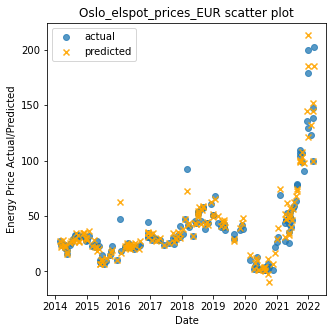

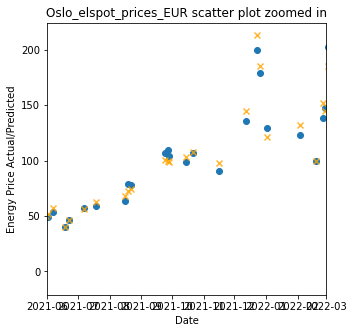

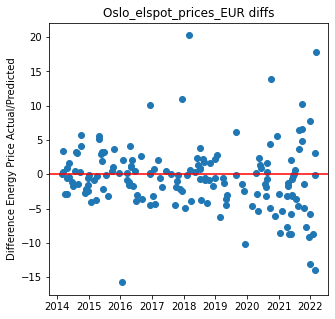

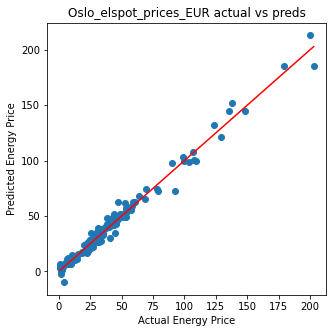

Test set results for  Bergen_elspot_prices_EUR
explained_variance:  0.1092
r2:  -0.002
MAE:  14.8276
MSE:  1194.1161
RMSE:  34.556
MAPE:  34.556
Worst error: 185.3


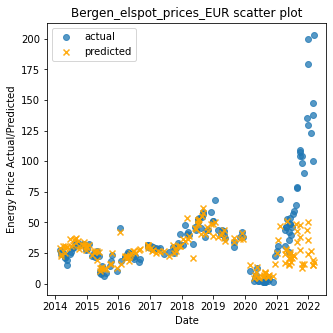

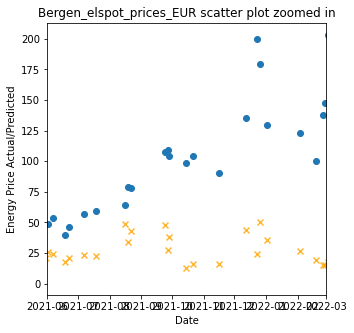

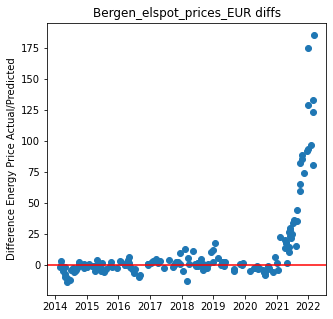

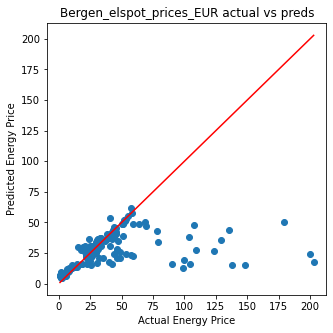

Test set results for  Molde_elspot_prices_EUR
explained_variance:  0.7739
r2:  0.7449
MAE:  4.7125
MSE:  65.6636
RMSE:  8.1033
MAPE:  8.1033
Worst error: 48.52


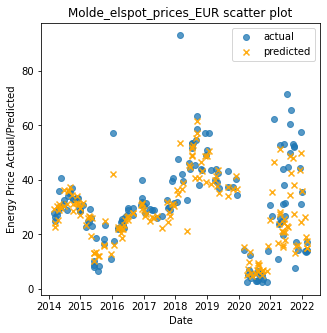

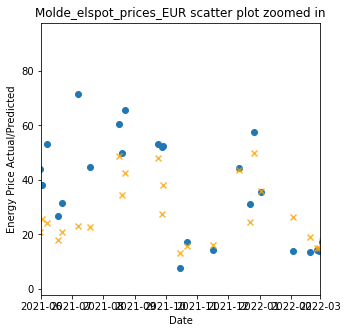

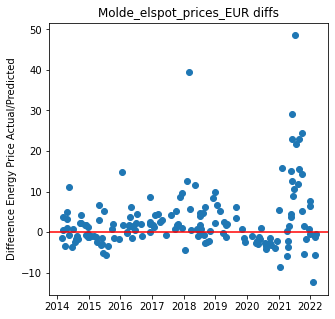

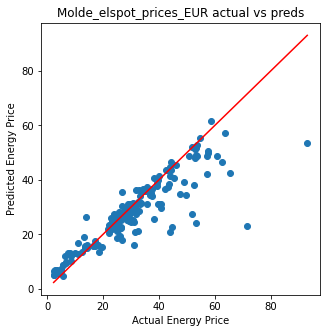

Test set results for  TromsÃ¸_elspot_prices_EUR
explained_variance:  0.8684
r2:  0.8672
MAE:  3.3259
MSE:  31.4632
RMSE:  5.6092
MAPE:  5.6092
Worst error: 39.55


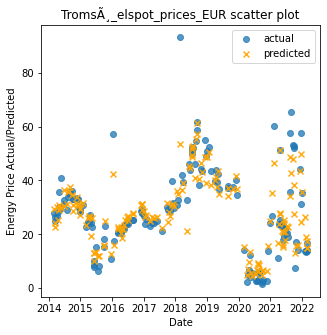

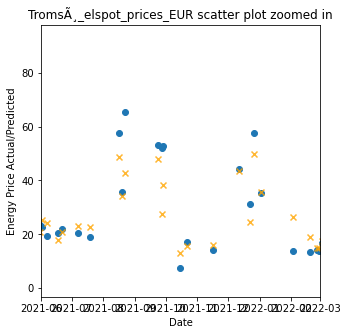

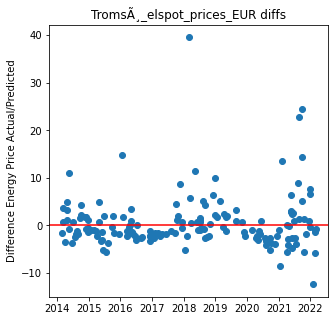

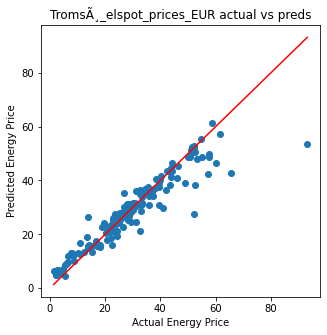

In [26]:
#for each model we have 
# train_test_sets = train_test_list
# tuned_models = tuned_model_list
for x in range(len(tuned_model_list)):
    print('Test set results for ',targets_list[x])
    features_test = train_test_list[x][1].copy() #get test set features
    target_true_test = train_test_list[x][3].copy() #get test set target
    temp_target_pred_test = tuned_model_list[x].predict(features_test) #make predictions
    temp_pred_diff = target_true_test - temp_target_pred_test #get diffs
    regression_results(target_true_test,temp_target_pred_test) #get results
    
    #plots
    plt.rcParams["figure.figsize"] = (5,5)
    
    #scatter plot pred vs actual
    plt.title(targets_list[x]+' scatter plot')
    plt.scatter(features_test.index,target_true_test,alpha=0.75,marker='o',label='actual')
    plt.scatter(features_test.index,temp_target_pred_test,alpha=0.9,c='orange',marker='x',label='predicted')
    plt.xlabel('Date')
    plt.ylabel('Energy Price Actual/Predicted')
    plt.legend()
    plt.show()
    
    #zoomed in on last year
    plt.title(targets_list[x]+' scatter plot zoomed in')
    plt.scatter(features_test.index,target_true_test,alpha=1.0,marker='o',label='actual')
    plt.scatter(features_test.index,temp_target_pred_test,alpha=0.8,c='orange',marker='x',label='predicted')
    plt.xlim([datetime.date(2021, 6, 1), datetime.date(2022, 3, 1)])
    plt.xlabel('Date')
    plt.ylabel('Energy Price Actual/Predicted')
#     plt.ylim(0,100)
    plt.show()
    
    #skip line graph if train test shuffled
    if SHUFFLED == False:
        plt.title(targets_list[x]+' line plot')
        plt.plot(features_test.index,target_true_test,alpha=1,marker='.',label='actual')
        plt.plot(features_test.index,temp_target_pred_test,alpha=0.8,c='orange',marker='.',label='predicted')
        plt.show()
    else:
        pass
    
    plt.title(targets_list[x]+' diffs')
    plt.scatter(features_test.index,temp_pred_diff)
    plt.ylabel('Difference Energy Price Actual/Predicted')
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.show()
    
    plt.title(targets_list[x]+' actual vs preds')
    plt.scatter(target_true_test,temp_target_pred_test)
    plt.xlabel('Actual Energy Price')
    plt.ylabel('Predicted Energy Price')
    min_point = min(target_true_test)
    max_point = max(target_true_test)
    plt.plot([min_point,max_point],[min_point,max_point],color='r')
    plt.show()
    
    
